## Course-end Project 3: Online Retail Store Customer RFM Segmentation 

DESCRIPTION

It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.
Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits
Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).
Dataset Description

This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.


#### Variables	Description
***
* **InvoiceNo**:  Invoice number. Nominal, a six digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
***
* **StockCode**: 	Product (item) code. Nominal, a five digit integral number uniquely assigned to each distinct product
***
* **Description**: 	Product (item) name. Nominal
***
* **Quantity**: 	The quantities of each product (item) per transaction. Numeric
***
* **InvoiceDate**: 	Invoice Date and time. Numeric, the day and time when each transaction was generated
***
* **UnitPrice**: 	Unit price. Numeric, product price per unit in sterling
***
* **CustomerID**: 	Customer number. Nominal, a six digit integral number uniquely assigned to each customer
***
* **Country**: 	Country name. Nominal, the name of the country where each customer resides
***

### Data Cleaning:

1. Perform a preliminary data inspection and data cleaning.

 * Check for missing data and formulate an apt strategy to treat them.
 * Remove duplicate data records.
 * Perform descriptive analytics on the given data.

To have more accurate EDA (Exploratory Data Analysis) I have decided to use the full dataset by contcatanating both Train and Test datasets as they are provided in separated files. This will give an opportunity to have more accurate hypothesis or observations also complete data wrangling and cleaning into one concatanated dataset. For data modelling I will split them again into Test and Train sets.

In [1]:
import pandas as pd
import numpy as np

# For plots and visualizations
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# setting max display column limit to 30
pd.set_option("display.max_columns", 30)

#To use SNS chart formatting instead of matplotlib defaults



In [2]:
# Importing train dataset
dTrain = pd.read_excel('train.xlsx')

# Importing test dataset
dTest = pd.read_excel('test.xlsx')

# Contcatanating train and test datssets

df = pd.concat([dTrain, dTest], axis=0)

# After Data cleaning and after EDA, separating them back to test and train set for providing input to model

In [3]:
df.head()

InvoiceNo StockCode                         Description  Quantity  \
0    558904     22292    HANGING CHICK  YELLOW DECORATION         1   
1    556072     20970  PINK FLORAL FELTCRAFT SHOULDER BAG         8   
2    551739     21559   STRAWBERRY LUNCH BOX WITH CUTLERY         2   
3    541658     21988        PACK OF 6 SKULL PAPER PLATES         1   
4    538364    85099C      JUMBO  BAG BAROQUE BLACK WHITE        10   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2011-07-04 16:18:00       1.25         NaN  United Kingdom  
1 2011-06-08 14:57:00       3.75     16126.0  United Kingdom  
2 2011-05-04 10:58:00       2.55     18118.0  United Kingdom  
3 2011-01-20 12:16:00       0.85     15529.0  United Kingdom  
4 2010-12-10 17:26:00       1.95     14448.0  United Kingdom

In [4]:
# Checking number of unique values in each column
for col in df.columns:
    print(col, ': ', df[col].nunique())

InvoiceNo :  25900
StockCode :  4070
Description :  4223
Quantity :  722
InvoiceDate :  23260
UnitPrice :  1630
CustomerID :  4372
Country :  38


In [5]:
df.shape

(541909, 8)

In [6]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541909 entries, 0 to 162572
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 37.2+ MB


In [8]:
df.describe().transpose()

count          mean          std       min       25%       50%  \
Quantity    541909.0      9.552250   218.081158 -80995.00      1.00      3.00   
UnitPrice   541909.0      4.611114    96.759853 -11062.06      1.25      2.08   
CustomerID  406829.0  15287.690570  1713.600303  12346.00  13953.00  15152.00   

                 75%      max  
Quantity       10.00  80995.0  
UnitPrice       4.13  38970.0  
CustomerID  16791.00  18287.0

**Observation:**

A look at the quantity column reveals there are some negative values. Those could be possibly the refunds or cancellation. The refunds start from the 'C' in InvoiceNo.

Minimum value for a Quantity is in negative and the same number is positive in the max; which means someone bought 80,995 products but then returned later.

If we look at the unit price, all the quartiles are in single digit numbers but the max value is in thousands, which creates some doubt.

Let's analyse all these all points & if required remove them from the data.

## Data Cleaning
### Missing Values

In [9]:
missing = df.columns[df.isnull().any()].tolist()
missing_list = df[missing].isnull().sum().sort_values(ascending=False)

print('Missing data count')
print(missing_list)
print('**'*10)
print('  ')
print('Missing Data Percentage')
print(round(missing_list / len(df)*100, 2))

Missing data count
CustomerID     135080
Description      1454
dtype: int64
********************
  
Missing Data Percentage
CustomerID     24.93
Description     0.27
dtype: float64


#### Observation:
    * 24.93% of purchased items are not assigned to any customer.
    * 0.27%  of purchased items are without any description.
    * We cannot cluster them without CustomerID or without item descriptions.
    * Therefore we delete both missing values from CustomerID and description.
    
  
    

Text(0.5, 1.0, ' Visualising Missing Values')

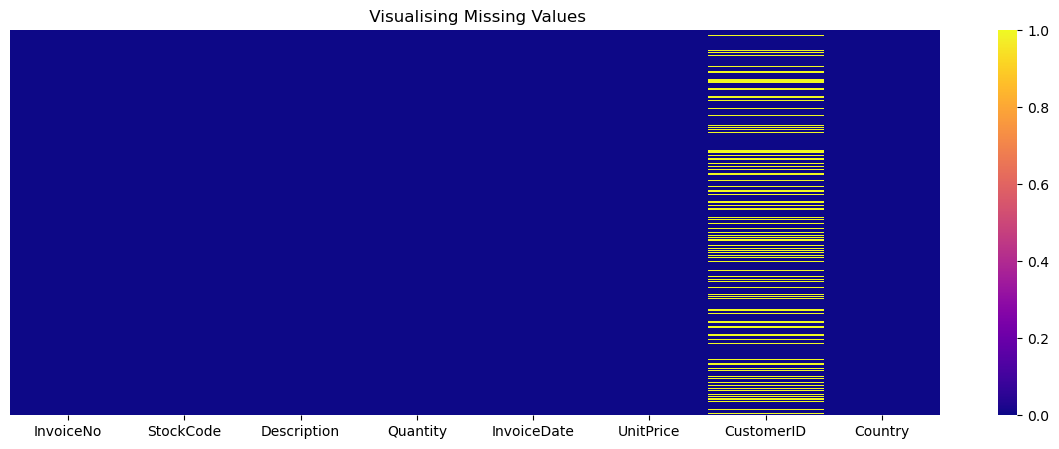

In [10]:
# Visulaizing null values using heatmap.
plt.figure(figsize=(15,5))
sns.heatmap(df.isnull(),cmap='plasma',annot=False,yticklabels=False)
plt.title(" Visualising Missing Values")

In [11]:
# Droping Null values
df.dropna(inplace=True)

In [12]:
df.shape

(406829, 8)

In [13]:
df.describe()

Quantity      UnitPrice     CustomerID
count  406829.000000  406829.000000  406829.000000
mean       12.061303       3.460471   15287.690570
std       248.693370      69.315162    1713.600303
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13953.000000
50%         5.000000       1.950000   15152.000000
75%        12.000000       3.750000   16791.000000
max     80995.000000   38970.000000   18287.000000

#### Obseravations:
* Quantity has negative figure
* Unit price has zero as min value  \
Need to explore these columns and take necessary actions to remove them

### Removing Negative values:
* Lets assign all the cancallation invoices (starting with 'C') and negative values to a separate dataset as df_C for seperate EDA
* Therafter we can drop all quantities with negative Stock figures and Invoice numbers starting with 'C' from those respective cloumns


In [14]:
# Checking all the records which were returned
df_C = df[df["InvoiceNo"].str.startswith('C',na=False)]
df_C

InvoiceNo StockCode                         Description  Quantity  \
415      C549269    75049L        LARGE CIRCULAR MIRROR MOBILE        -9   
487      C572109     23064              CINDERELLA CHANDELIER         -1   
613      C537860     22180                      RETROSPOT LAMP        -1   
834      C560540     23240   SET OF 4 KNICK KNACK TINS DOILEY         -1   
874      C542910     20726                  LUNCH BAG WOODLAND        -1   
...          ...       ...                                 ...       ...   
162302   C558712     21735              TWO DOOR CURIO CABINET        -1   
162334   C550780    84507C     BLUE CIRCLES DESIGN MONKEY DOLL        -1   
162344   C553031     21533            RETROSPOT LARGE MILK JUG        -3   
162421   C542910    85123A  WHITE HANGING HEART T-LIGHT HOLDER        -1   
162458   C543368     22941        CHRISTMAS LIGHTS 10 REINDEER        -4   

               InvoiceDate  UnitPrice  CustomerID         Country  
415    2011-04-07 12:47:00       0.85     16701.0  United Kingdom  
487    2011-10-20 18:24:00      49.95     13350.0  United Kingdom  
613    2010-12-08 16:15:00       9.95     16252.0  United Kingdom  
834    2011-07-19 12:26:00       4.15     12415.0       Australia  
874    2011-02-01 15:38:00       1.45     17511.0  United Kingdom  
...                    ...        ...         ...             ...  
162302 2011-07-01 13:06:00      12.75     17338.0  United Kingdom  
162334 2011-04-20 13:39:00       2.55     17211.0  United Kingdom  
162344 2011-05-12 19:43:00       4.95     13908.0  United Kingdom  
162421 2011-02-01 15:38:00       2.55     17511.0  United Kingdom  
162458 2011-02-07 14:46:00       8.50     18245.0  United Kingdom  

[8905 rows x 8 columns]

In [15]:
# Deleting all the records which were returned 
df=df[~df['InvoiceNo'].str.startswith('C',na=False)]

In [16]:
df.shape

(397924, 8)

In [17]:
#check if any negatives are left 
len(df[df['Quantity']<0])

0

In [18]:
df.describe()

Quantity      UnitPrice     CustomerID
count  397924.000000  397924.000000  397924.000000
mean       13.021823       3.116174   15294.315171
std       180.420210      22.096788    1713.169877
min         1.000000       0.000000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
max     80995.000000    8142.750000   18287.000000

**Observations:**
    We can see that there are no more negatives value quantityes as they were assigned only to 'C' invoices and we removed already. There are unit price with 0 value which we have to remove from our dataset.

#### Removing zero Unit prices 

In [19]:
# Checking nos of negative or  unit prices
len(df[df['UnitPrice']==0])

40

#### Observation:
* zero valued unit price could be a contents of return or cancelled item or a outlier, hence they have to be removed and cannot be used for any EDA (Exploratory Data Analysis)

In [20]:
# Remove 0 values by targetting only the values >0
df = df[df['UnitPrice']>0]

In [21]:
df.describe()

Quantity      UnitPrice     CustomerID
count  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488   15294.423453
std       179.331775      22.097877    1713.141560
min         1.000000       0.001000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
max     80995.000000    8142.750000   18287.000000

### Removing duplicate entries

In [22]:
# Checking for duplicate 
print(len(df[df.duplicated()]))

5192


Drop the duplicates

In [23]:
df.drop_duplicates(keep='first', inplace=True)

In [24]:
# Checking for duplicate 
print(len(df[df.duplicated()]))

0


In [151]:
# Creating a new feature 'Total_Sales'
df['Total_Sales']= df['Quantity'] * df['UnitPrice']

In [26]:
df.shape

(392692, 9)

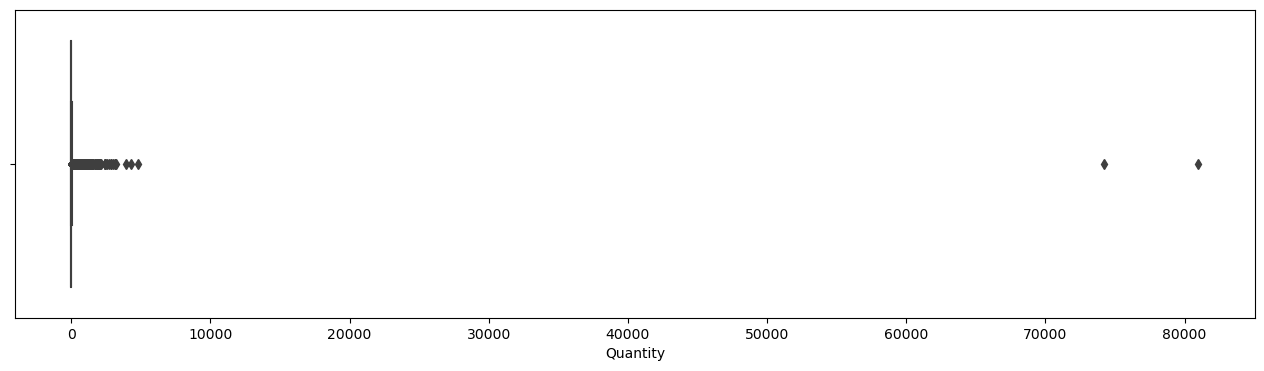

In [27]:
plt.figure(figsize=(16,4))

sns.boxplot(x='Quantity', data=df,  orient='h');

There are 2 distinctive outliers.

In [28]:
df.describe().transpose()

count          mean          std        min       25%  \
Quantity     392692.0     13.119702   180.492832      1.000      2.00   
UnitPrice    392692.0      3.125914    22.241836      0.001      1.25   
CustomerID   392692.0  15287.843865  1713.539549  12346.000  13955.00   
Total_Sales  392692.0     22.631500   311.099224      0.001      4.95   

                  50%       75%        max  
Quantity         6.00     12.00   80995.00  
UnitPrice        1.95      3.75    8142.75  
CustomerID   15150.00  16791.00   18287.00  
Total_Sales     12.45     19.80  168469.60

In [29]:
# Looking for high valued outliers
df[['InvoiceNo','Quantity']].sort_values( 'Quantity',ascending=False).head(5)

InvoiceNo  Quantity
43525     581483     80995
322892    541431     74215
15177     573008      4800
157187    554868      4300
367920    544612      3906

**Observation:**

InvoiceNO: 581483 and 541431 with high number of quantities are outliers
as there is a huge deviation from the mean.  So we can drop those two.

In [30]:
# Deleting record for Inovice no. 581483 and 541431

df.drop([43525, 322892],inplace = True)

df[['InvoiceNo','Quantity']].sort_values( 'Quantity',ascending=False).head(5)


InvoiceNo  Quantity
15177     573008      4800
157187    554868      4300
367920    544612      3906
273934    560599      3186
6586      540815      3114

In [31]:
df.describe().transpose()

count          mean          std        min       25%  \
Quantity     392689.0     12.724543    43.083698      1.000      2.00   
UnitPrice    392689.0      3.125924    22.241920      0.001      1.25   
CustomerID   392689.0  15287.846566  1713.538278  12347.000  13955.00   
Total_Sales  392689.0     22.006084    96.770730      0.001      4.95   

                  50%       75%       max  
Quantity         6.00     12.00   4800.00  
UnitPrice        1.95      3.75   8142.75  
CustomerID   15150.00  16791.00  18287.00  
Total_Sales     12.45     19.80  38970.00

**Observation:**

No more outliers

In [32]:
orders_n = df.groupby(['CustomerID']) ['InvoiceNo'].nunique()
more_than_one = np.sum(orders_n > 1) / df['CustomerID'].nunique()
print(f'{100 * more_than_one:.2f}% of customers ordered more than once')


65.58% of customers ordered more than once


**Observation:**

We have already got a very useful piece of information here. We see there is some kind of retention rate, as 65.56% of customers have ordered from the website atleast more than once

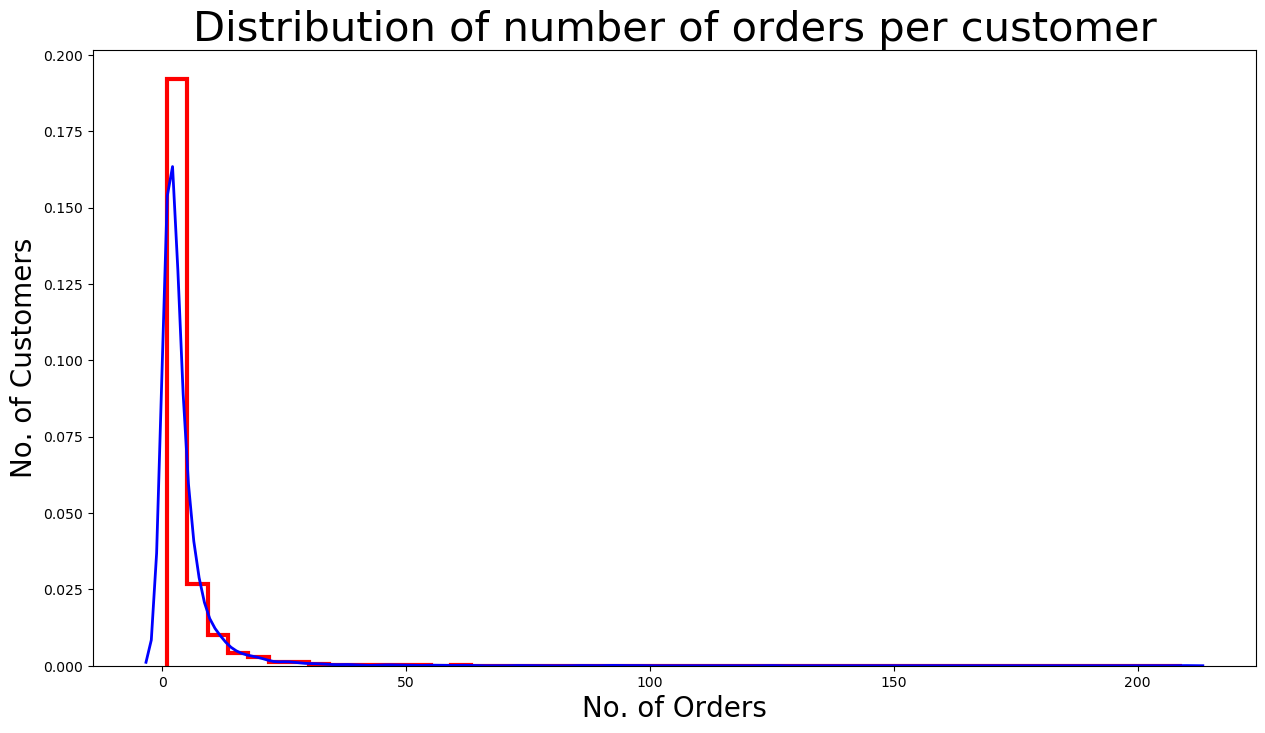

In [33]:
plt.figure(figsize=(15,8))
plt.style.use('_classic_test_patch')
px = sns.distplot(orders_n, hist = True, rug_kws={"color": "r"},
                  kde_kws={"color": "b", "lw": 2, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "r"})

px.set_title('Distribution of number of orders per customer', fontsize = 30)
px.set_xlabel('No. of Orders', fontsize = 20)
px.set_ylabel('No. of Customers', fontsize = 20);
plt.show()

In [34]:
df_copy = df.copy()

## EDA (Exploratory Data Analysis)

In [35]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total_Sales'],
      dtype='object')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392689 entries, 1 to 162572
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392689 non-null  object        
 1   StockCode    392689 non-null  object        
 2   Description  392689 non-null  object        
 3   Quantity     392689 non-null  int64         
 4   InvoiceDate  392689 non-null  datetime64[ns]
 5   UnitPrice    392689 non-null  float64       
 6   CustomerID   392689 non-null  float64       
 7   Country      392689 non-null  object        
 8   Total_Sales  392689 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


## Top 10 items sold

In [37]:
top_10_product = df['Description'].value_counts().reset_index().rename(columns={'index':'Product_name','Description':'Count'}).head(10)
top_10_product

Product_name  Count
0  WHITE HANGING HEART T-LIGHT HOLDER   2016
1            REGENCY CAKESTAND 3 TIER   1713
2             JUMBO BAG RED RETROSPOT   1615
3       ASSORTED COLOUR BIRD ORNAMENT   1395
4                       PARTY BUNTING   1389
5             LUNCH BAG RED RETROSPOT   1303
6   SET OF 3 CAKE TINS PANTRY DESIGN    1152
7                             POSTAGE   1099
8             LUNCH BAG  BLACK SKULL.   1078
9     PACK OF 72 RETROSPOT CAKE CASES   1050

Text(0.5, 1.0, 'Top 10 products')

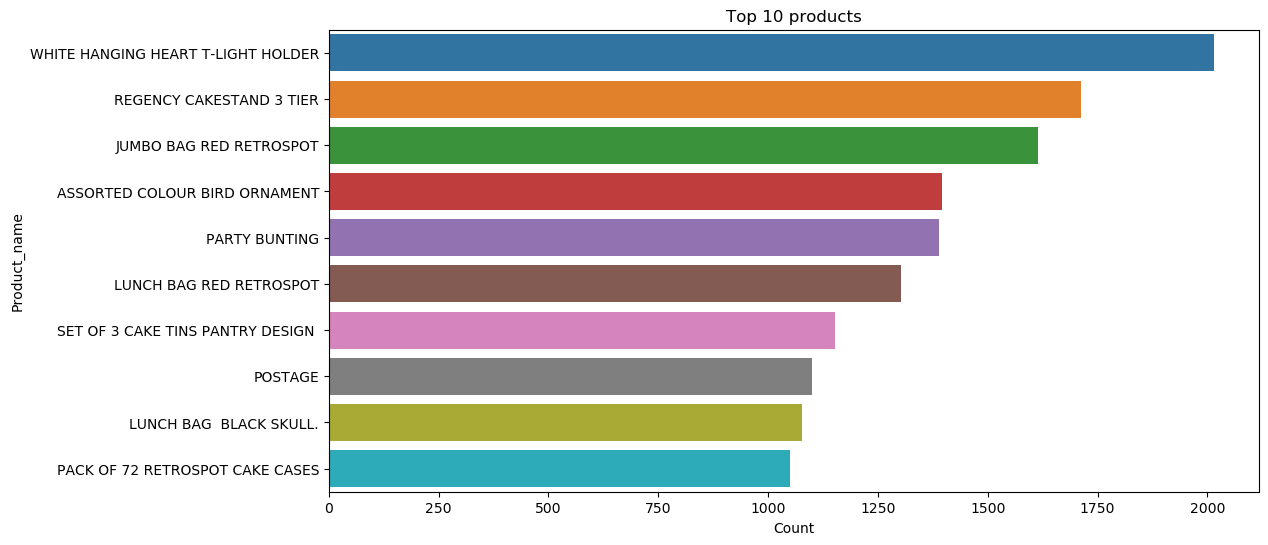

In [38]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_10_product['Count'], y=top_10_product['Product_name'])
plt.title('Top 10 products')

#### Observations:
* WHITE HANGING HEART T-LIGHT HOLDER is the highest selling product 2016 units were sold
* REGENCY CAKESTAND 3 TIER is the 2nd highest selling product almost 1723 units were sold

## Bottom 10 items sold

In [39]:
bottom_10_product = df['Description'].value_counts().reset_index().rename(columns={'index':'Product_name','Description':'Count'}).tail(10)
bottom_10_product

Product_name  Count
3866       GLASS AND BEADS BRACELET IVORY      1
3867           CRACKED GLAZE EARRINGS RED      1
3868          SILVER BOOK MARK WITH BEADS      1
3869  MIDNIGHT BLUE CRYSTAL DROP EARRINGS      1
3870       3 WICK CHRISTMAS BRIAR CANDLE       1
3871                 KNITTED RABBIT DOLL       1
3872               FLOWER SHOP DESIGN MUG      1
3873       FIRE POLISHED GLASS NECKL GOLD      1
3874      BEADED LOVE HEART JEWELLERY SET      1
3875   GREEN DROP EARRINGS W BEAD CLUSTER      1

Text(0.5, 1.0, 'bottom 10 products')

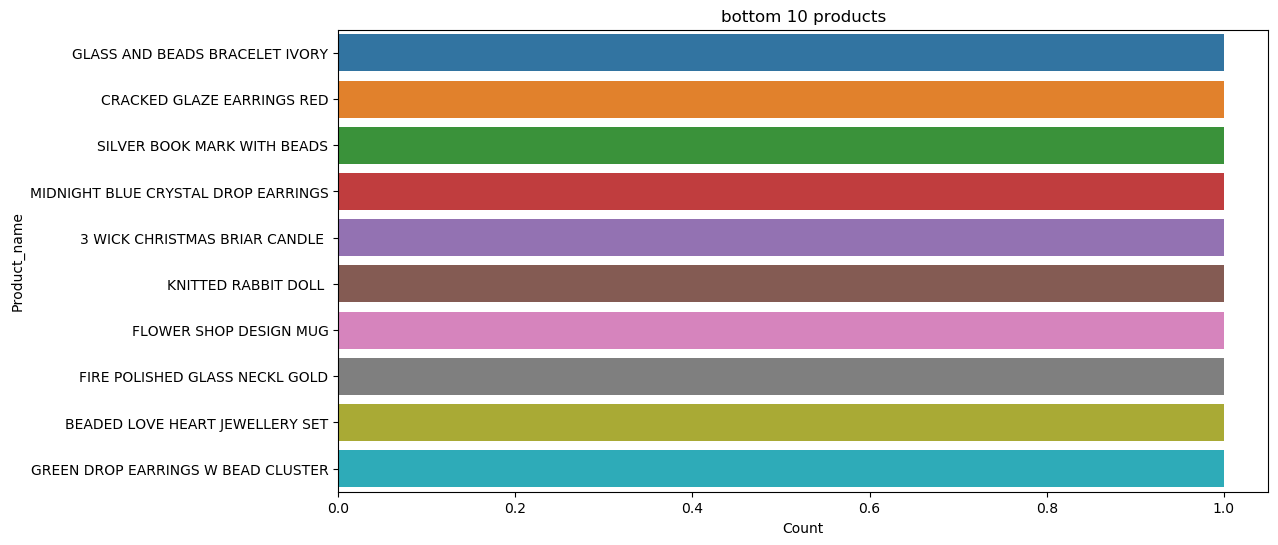

In [40]:
plt.figure(figsize=(12,6))
sns.barplot(x=bottom_10_product['Count'], y=bottom_10_product['Product_name'])
plt.title('bottom 10 products')

### Sales by Country

In [41]:
# Checking the values for top 15 countries in the dataset
df['Country'].value_counts().head(15)

United Kingdom     349200
Germany              9025
France               8326
EIRE                 7226
Spain                2479
Netherlands          2359
Belgium              2031
Switzerland          1841
Portugal             1453
Australia            1181
Norway               1071
Italy                 758
Channel Islands       747
Finland               685
Cyprus                603
Name: Country, dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392689 entries, 1 to 162572
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392689 non-null  object        
 1   StockCode    392689 non-null  object        
 2   Description  392689 non-null  object        
 3   Quantity     392689 non-null  int64         
 4   InvoiceDate  392689 non-null  datetime64[ns]
 5   UnitPrice    392689 non-null  float64       
 6   CustomerID   392689 non-null  float64       
 7   Country      392689 non-null  object        
 8   Total_Sales  392689 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


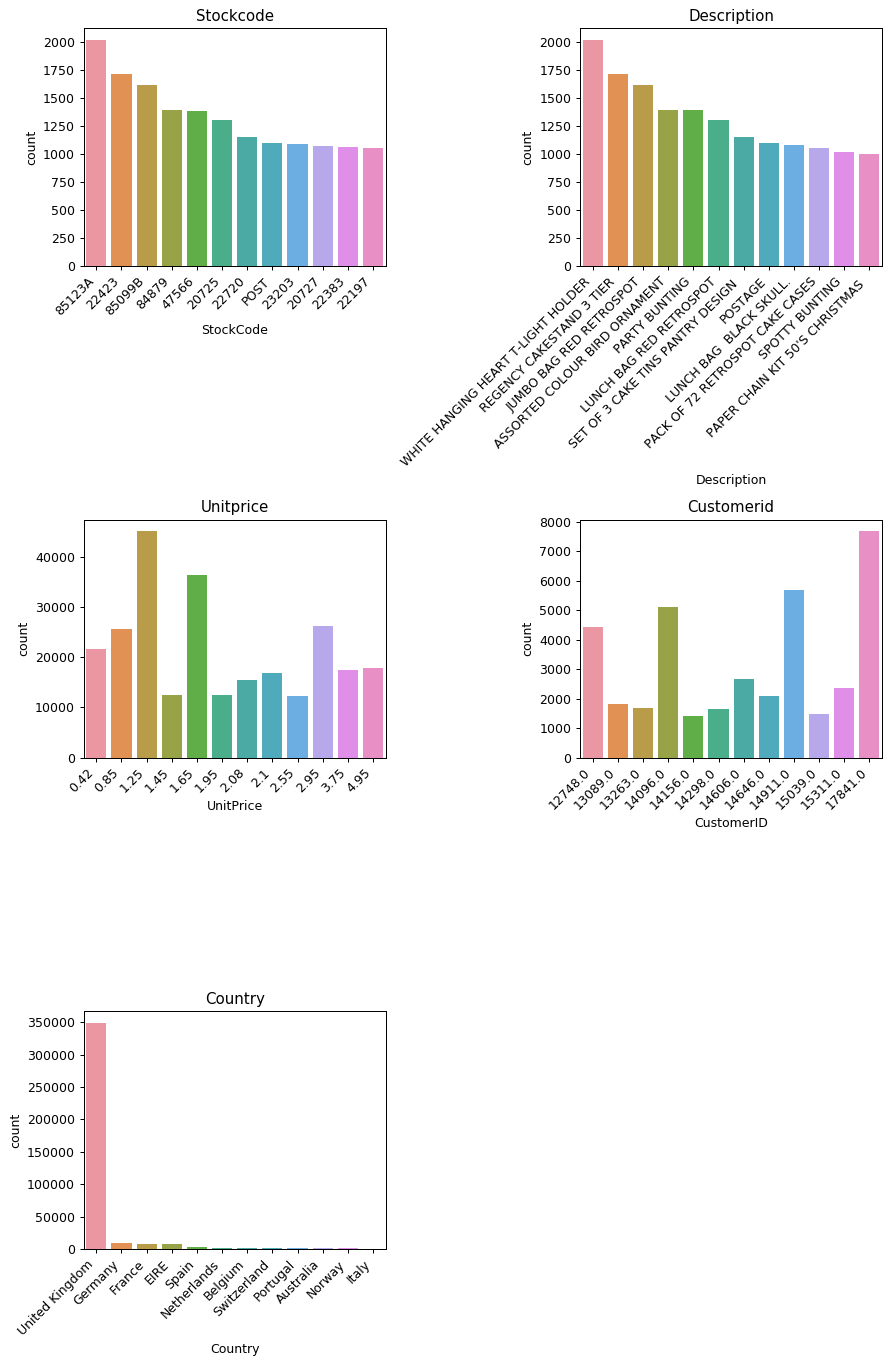

In [43]:
target = ['StockCode', 'Description', 'UnitPrice', 'CustomerID', 'Country']

plt.figure(figsize=(10,25), dpi=90)
for n, col in enumerate(target):
    plt.subplot(5,2, n+1)
    temp = df[col].value_counts().reset_index().head(12)
    temp.rename(columns={'index': col, col: 'count'}, inplace=True)
    sns.barplot(x=col, y='count', data=temp).set(title=col.title())
    plt.xticks(rotation=45, ha= 'right')
    plt.tight_layout()

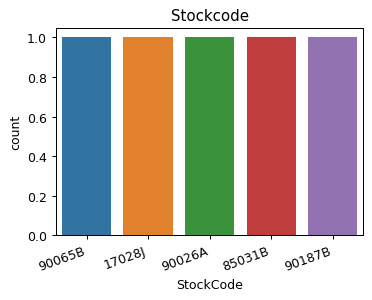

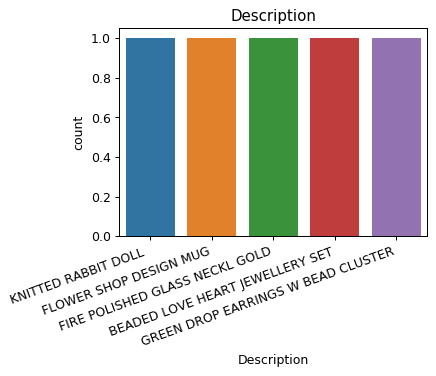

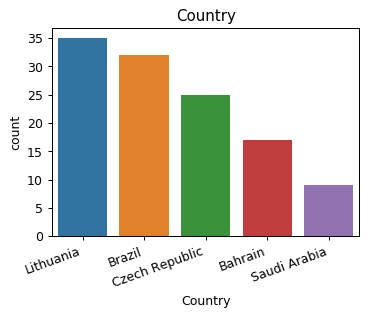

In [44]:
# Plotting bottom 5 values:
target = ['StockCode', 'Description', 'Country']

for n, col in enumerate(target):
    plt.figure(figsize=(15,3), dpi=90)
    plt.subplot(1,3, n+1)
    temp = df[col].value_counts().reset_index().tail(5)
    temp.rename(columns={'index':col, col:'count'}, inplace=True)
    sns.barplot(x=col, y= 'count', data=temp).set(title=col.title())
    plt.xticks(rotation=20, ha='right')
    #plt.tight_layout()
    

#### Obseravtion/Hypothesis:
1.  **Countrywise Orders:** Most Customers are from United Kingdom. Far at second place Germany. France, EIRE and Spain are third, fourth and fifth places respectively. Whereas Saudi Arabia is the lowest and followed by Bahrain, Czech Republic, Brazil and Lithuania respectively has the lest number of cutomers.
2. **Day in weekwise Orders:**  No orders on Saturdays. Looks like non working day for the retailer. Highest orders are on Thursdays and on Fridays are the lowest.
3. **Monthwise orders:** Highest orders are in November follwoed by October, December and September respectively. The reason could be preparing for festival period. The lowest number of purchses are in month of April followed by January and February respectively.
4. **Time of Day:** In the afternoon recorded the highest number of orders meanwhile evening is lowest orders by far.
5. **Itemwise:** WHITE HANGING HEART T-LIGHT HOLDER	2016, REGENCY CAKESTAND 3 TIER and JUMBO BAG RED RETROSPOT are the ordered products.
6. **Yearlywise:** The year 2011 has reorded the highest number of orders.
    

### Visualizing the distributions:
Using the seaborn.distplot() function to plot the distplot. The distplot represents the univariate distribution of data i.e. data distribution of a variable against the density distribution.

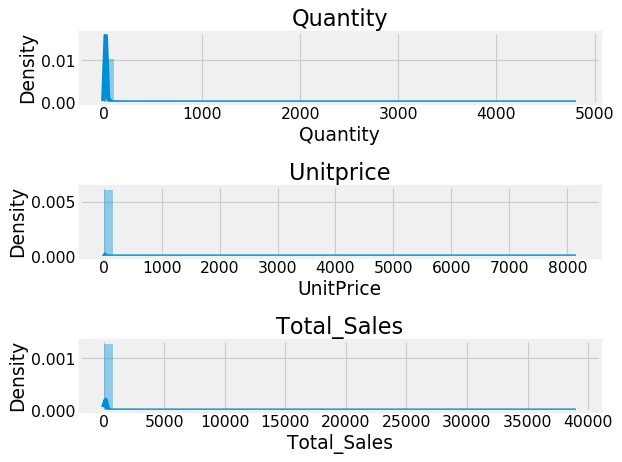

In [45]:
target = ['Quantity','UnitPrice','Total_Sales']

figure(figsize=(8, 6), dpi=80)
plt.style.use('fivethirtyeight')

for n,col in enumerate(target):
    plt.subplot(3, 1, n+1)
    sns.distplot(df_copy[col])
    plt.title(col.title())
    plt.tight_layout()

**Observation:**
1. It shows a positively skewed distribution becaucse most of the values are clustered around the left side of the distribution while the right tail of the distribution is longer, which means mean>median>mode.
2. For symmetric graph mean=median=mode. 

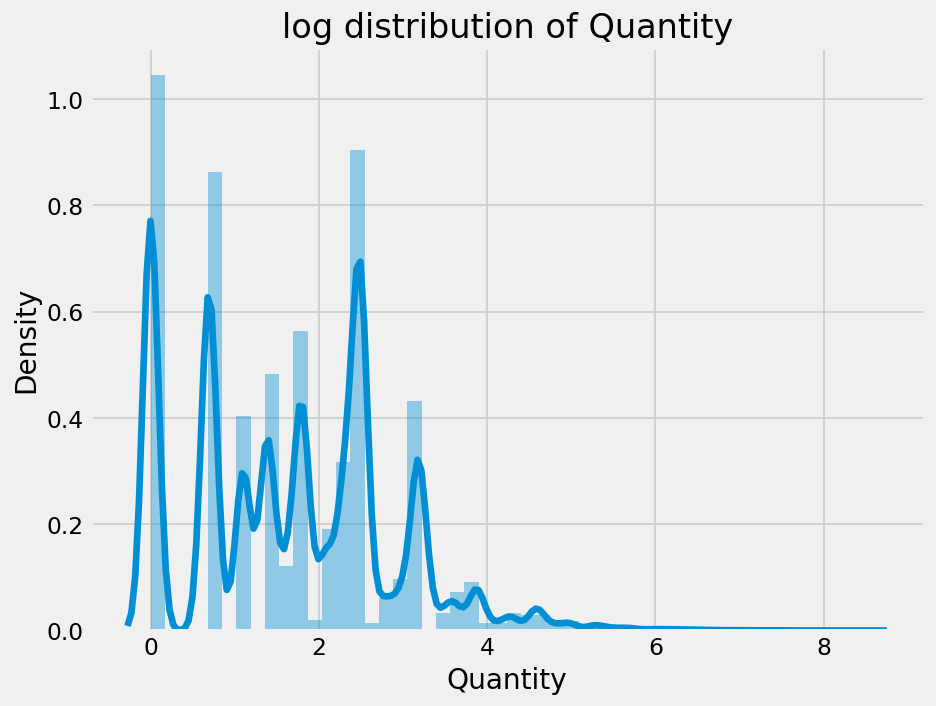

In [46]:
# Visualizing the distributions after log transformation of Quantity
plt.figure(figsize=(8,6), dpi=120)
plt.title('log distribution of Quantity')
plt.style.use('fivethirtyeight')
sns.distplot(np.log(df_copy['Quantity']))
plt.show()


#### Visulaizing top and bottom 10 countries based on total Invoices:

In [47]:
Country_Invoice = df.groupby("Country").nunique()["InvoiceNo"].reset_index().sort_values("InvoiceNo",ascending=False)
Country_Invoice.rename(columns={'InvoiceNo': 'Invoice_Count'}, inplace=True)
Country_Invoice.head(10)

Country  Invoice_Count
35  United Kingdom          16644
14         Germany            457
13          France            389
10            EIRE            260
3          Belgium             98
23     Netherlands             94
30           Spain             90
0        Australia             57
26        Portugal             57
32     Switzerland             51

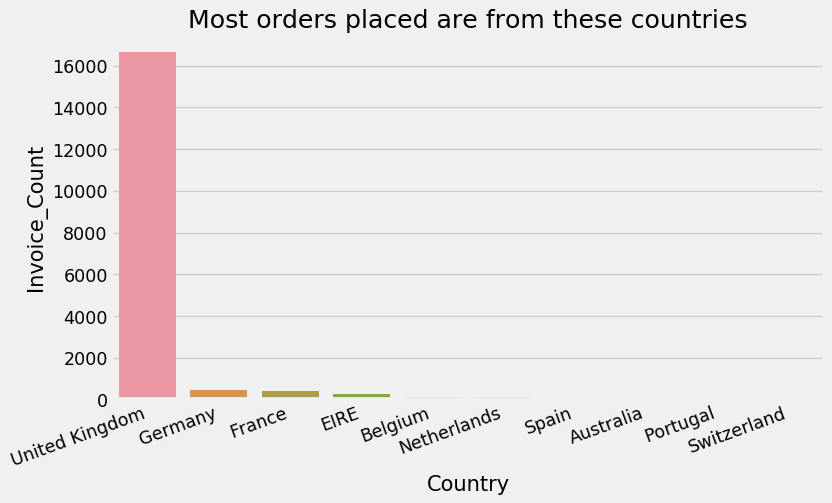

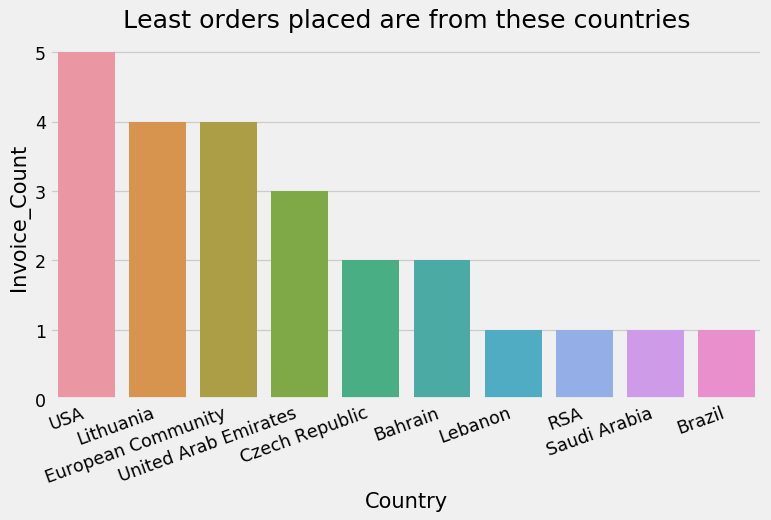

In [48]:
#Top 10 Countries:
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20, ha='right')
plt.title("Most orders placed are from these countries")
sns.barplot(data=Country_Invoice.head(10), x="Country", y="Invoice_Count")

#Bottom 10 Contries:
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20, ha='right')
plt.title("Least orders placed are from these countries")
sns.barplot(data=Country_Invoice.tail(10), x="Country", y="Invoice_Count")
plt.show()


#### *Observation:*
* UK is making the most purcahses compare to other countries while Brazil has the lowest purchases. We could consider UK as a group is an outlier as the deviation from the mean is significant. As it is not available, the reason for this and also we do not do any countrywise KPI comparisons. UK segment is important for analyzing other customer related metrics. 


#### Visulaizing top and bottom 10 countries based on number of customers:

In [49]:
# Most customers are from these countries
country_cust = df.groupby("Country").nunique()["CustomerID"].reset_index().sort_values("CustomerID",ascending=False)
country_cust.rename(columns={'CustomerID': 'Customer_Count'}, inplace=True)
country_cust.head(10)

Country  Customer_Count
35  United Kingdom            3919
14         Germany              94
13          France              87
30           Spain              30
3          Belgium              25
32     Switzerland              21
26        Portugal              19
18           Italy              14
12         Finland              12
1          Austria              11

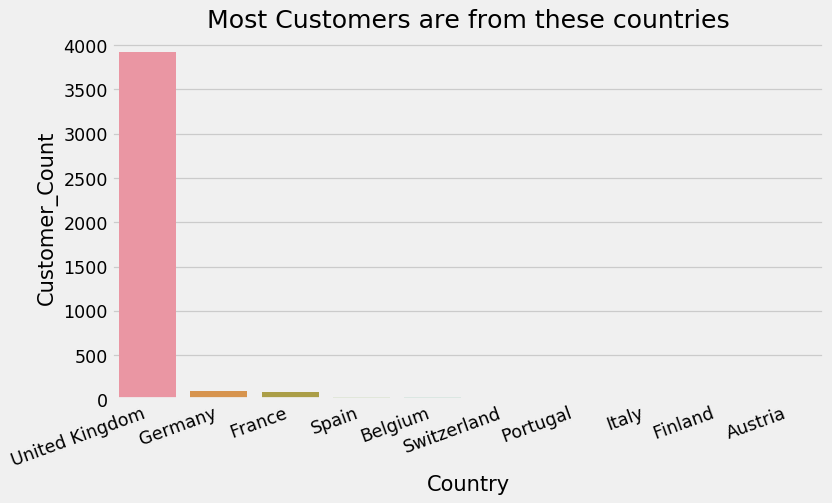

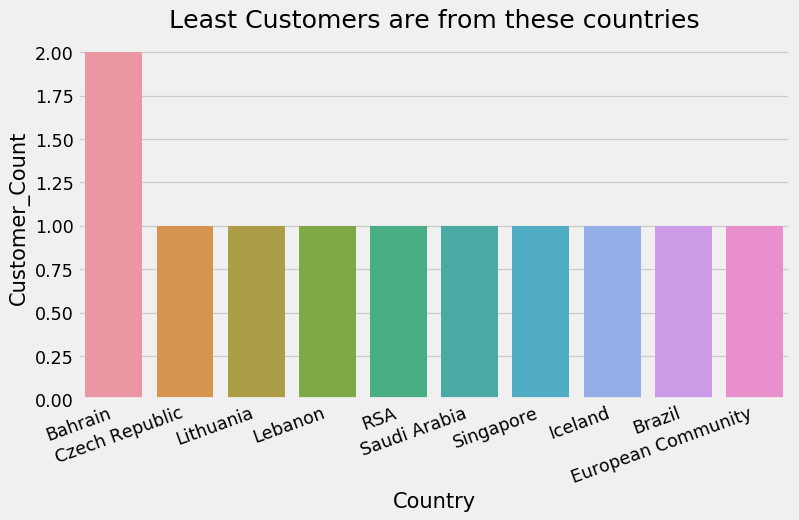

In [50]:
# Visualizing top 10 Countries based on customers:
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20, ha='right')
plt.title("Most Customers are from these countries")
sns.barplot(data=country_cust.head(10),x="Country", y="Customer_Count")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20, ha='right')
plt.title("Least Customers are from these countries")
sns.barplot(data=country_cust.tail(10),x="Country", y="Customer_Count")
plt.show()

#### Visualizing top and bottom 10 countries based on average item purchases 

In [51]:
# finding the mean value of quantity and converting into 'int' type
country_quantity = df.groupby('Country').mean()['Quantity'].apply(np.int).reset_index().sort_values('Quantity', ascending= False)
country_quantity.rename(columns={'Quantity': 'Average_Quantity'}, inplace=True)
country_quantity.head(10)

Country  Average_Quantity
23     Netherlands                84
19           Japan                81
31          Sweden                80
0        Australia                71
8   Czech Republic                26
29       Singapore                23
9          Denmark                21
10            EIRE                19
24          Norway                18
5           Canada                18

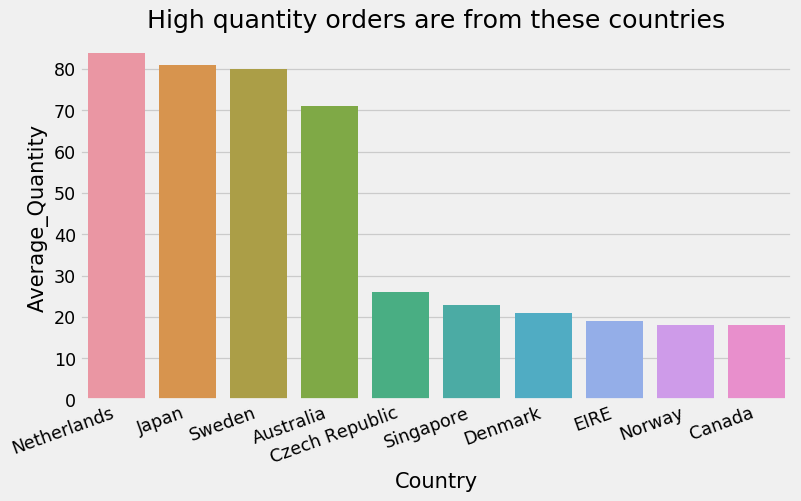

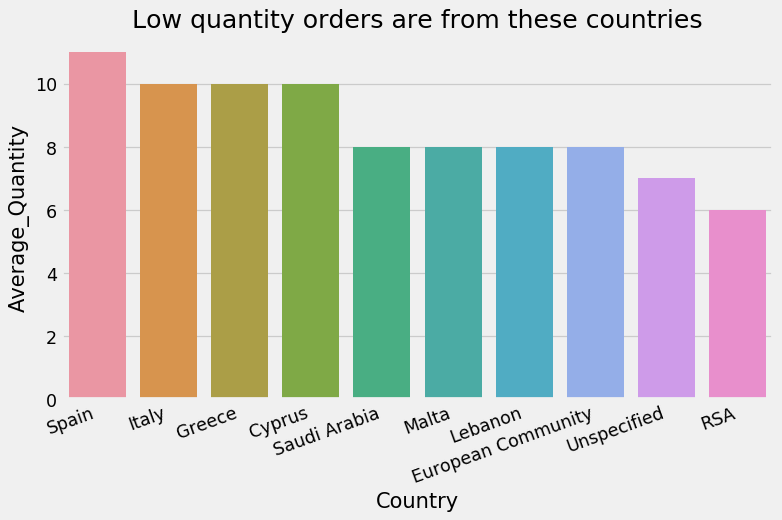

In [52]:
# Visualising top 10:
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20, ha = 'right')
plt.title("High quantity orders are from these countries")
sns.barplot(data=country_quantity.head(10),x="Country",y="Average_Quantity")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Low quantity orders are from these countries")
sns.barplot(data=country_quantity.tail(10),x="Country",y="Average_Quantity")
plt.show()

* Netherland recorded the highest number of purchases per customer

#### Visualizing top and bottom 10 products based on purchase quantity

In [53]:
# quantity wise item purchases
product_quantity = df.groupby("Description").sum()["Quantity"].reset_index().sort_values("Quantity",ascending=False)
product_quantity.head(10)

Description  Quantity
3785   WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
1762             JUMBO BAG RED RETROSPOT     46078
3697  WHITE HANGING HEART T-LIGHT HOLDER     36706
216        ASSORTED COLOUR BIRD ORNAMENT     35263
2269     PACK OF 72 RETROSPOT CAKE CASES     33670
2599                      POPCORN HOLDER     30919
2655                  RABBIT NIGHT LIGHT     27153
2047             MINI PAINT SET VINTAGE      26076
2235          PACK OF 12 LONDON TISSUES      25329
2267  PACK OF 60 PINK PAISLEY CAKE CASES     24230

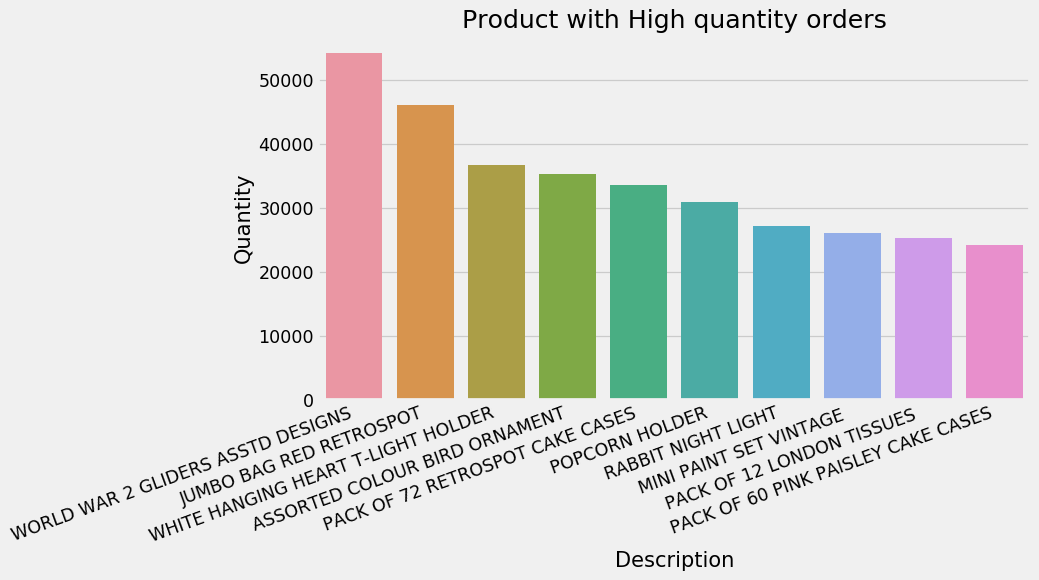

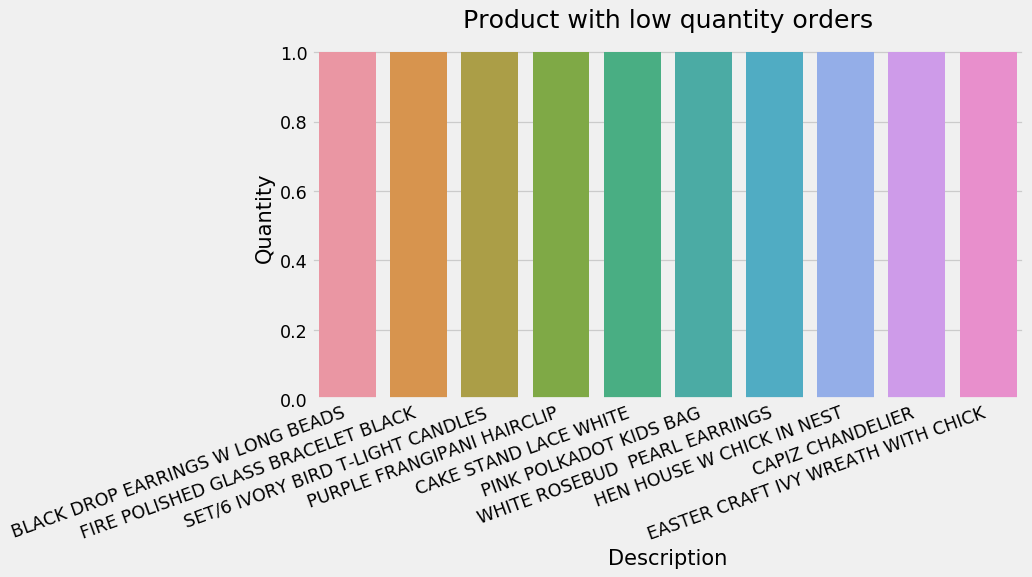

In [54]:

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Product with High quantity orders")
sns.barplot(data=product_quantity.head(10),x="Description",y="Quantity")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Product with low quantity orders")
sns.barplot(data=product_quantity.tail(10),x="Description",y="Quantity")
plt.show()

#### Visualizing top and bottom 10 products based on amount

In [55]:
# Amount wise item purchases
product_price = df.groupby("Description").sum()["Total_Sales"].reset_index().sort_values("Total_Sales",ascending=False)
product_price.head(10)

Description  Total_Sales
2766            REGENCY CAKESTAND 3 TIER    142264.75
3697  WHITE HANGING HEART T-LIGHT HOLDER    100392.10
1762             JUMBO BAG RED RETROSPOT     85040.54
2610                             POSTAGE     77803.96
2344                       PARTY BUNTING     68785.23
216        ASSORTED COLOUR BIRD ORNAMENT     56413.03
2130                              Manual     53419.93
2655                  RABBIT NIGHT LIGHT     51251.24
722                        CHILLI LIGHTS     46265.11
2313     PAPER CHAIN KIT 50'S CHRISTMAS      42584.13

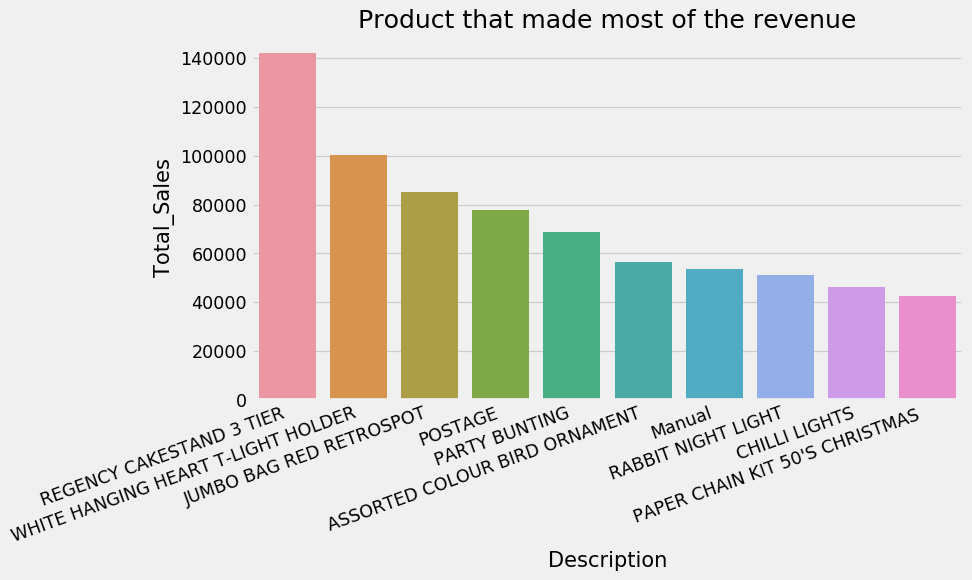

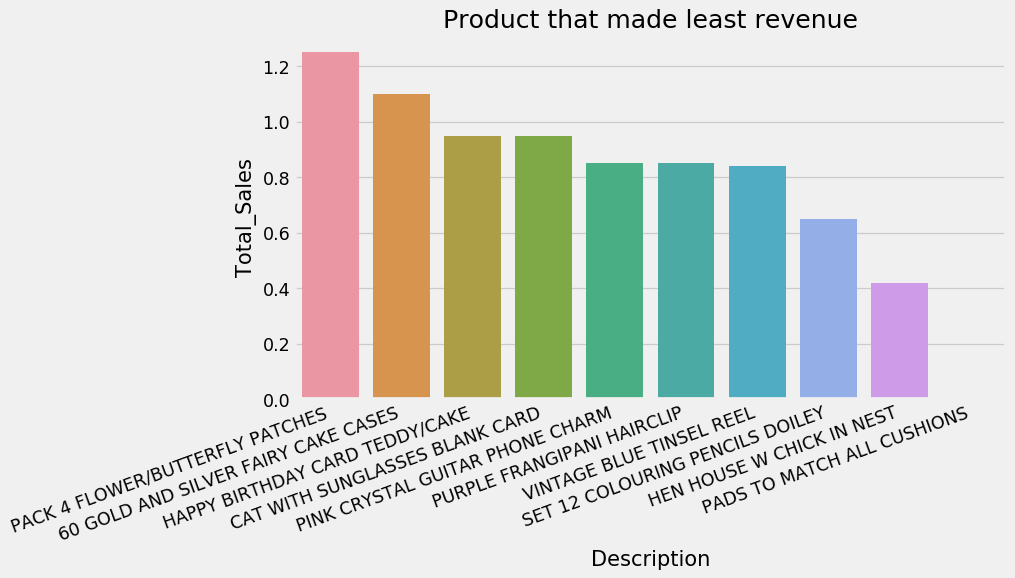

In [56]:
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Product that made most of the revenue")
sns.barplot(data=product_price.head(10),x="Description",y="Total_Sales")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Product that made least revenue")
sns.barplot(data=product_price.tail(10),x="Description",y="Total_Sales")
plt.show()

### Visualizing top and bottom 10 products based on customers

In [57]:
product_customer = df.groupby('Description').nunique()['CustomerID'].reset_index().sort_values('CustomerID', ascending=False)
product_customer.rename(columns={'CustomerID':'Customer_Count'}, inplace=True)
product_customer.head(10)

Description  Customer_Count
2766            REGENCY CAKESTAND 3 TIER             881
3697  WHITE HANGING HEART T-LIGHT HOLDER             856
2344                       PARTY BUNTING             708
216        ASSORTED COLOUR BIRD ORNAMENT             678
3000   SET OF 3 CAKE TINS PANTRY DESIGN              640
2269     PACK OF 72 RETROSPOT CAKE CASES             635
1762             JUMBO BAG RED RETROSPOT             635
2313     PAPER CHAIN KIT 50'S CHRISTMAS              613
2135     NATURAL SLATE HEART CHALKBOARD              587
269        BAKING SET 9 PIECE RETROSPOT              581

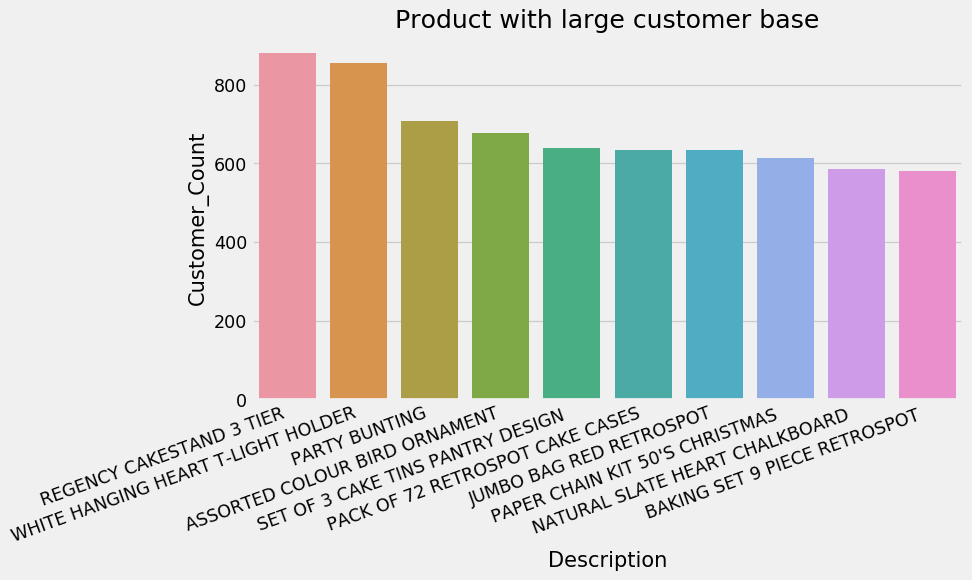

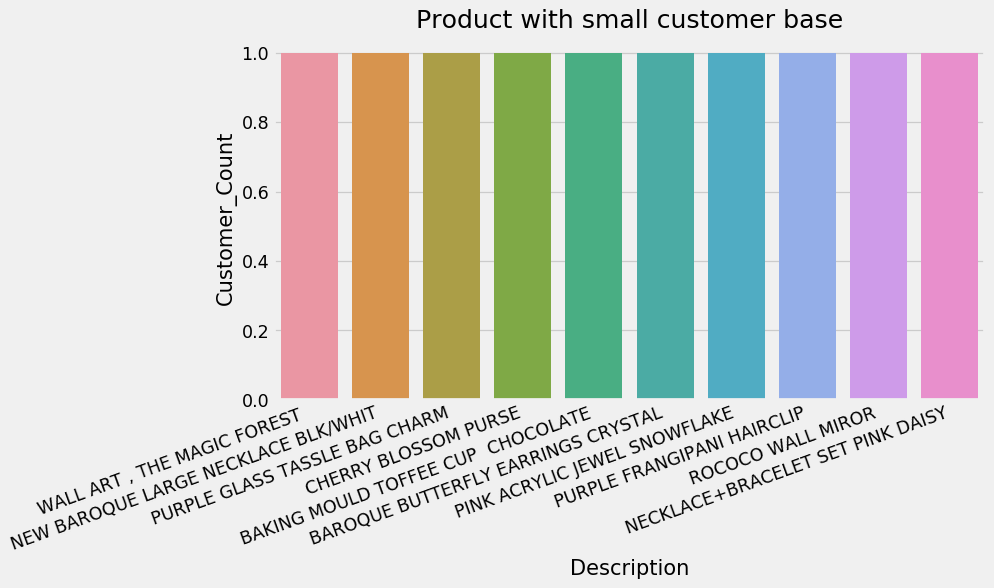

In [58]:
# Visualizing:
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Product with large customer base")
sns.barplot(data=product_customer.head(10),x="Description",y="Customer_Count")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Product with small customer base")
sns.barplot(data=product_customer.tail(10),x="Description",y="Customer_Count")
plt.show()

### Feature Engineering

In [59]:
# Create separate features for 'Year', 'Month_num', 'Day_num', 'Hour' and 'Minute' by splitting up 'InvoiceDate'

df_copy['Year'] = df_copy['InvoiceDate'].apply(lambda x: x.year)
df_copy['Month_num'] = df_copy['InvoiceDate'].apply(lambda x: x.month)
df_copy['day_num'] = df_copy['InvoiceDate'].apply(lambda x: x.day)
df_copy['Hour'] = df_copy['InvoiceDate'].apply(lambda x: x.hour)
df_copy['Minute'] = df_copy['InvoiceDate'].apply(lambda x: x.minute)

In [60]:
# Creating another 2 features of 'Day_of_Week' and 'Month' and extracting from 'InvoiceDate'

from datetime import datetime as dt
df_copy['Day_of_Week'] = df_copy['InvoiceDate'].dt.day_name()
df_copy['Month'] = df_copy['InvoiceDate'].dt.month_name()

In [61]:
# Creating a new feature 'Day_part' based on hours to define whether its Morning, Afternoon or Evening
def Day_part(hour):
    if hour in [5,6,7,8,9,10,11]:
        return "morning"
    elif hour in [12,13,14,15,16]:
        return "afternoon"
    elif hour in [17,18,19,20]:
        return "evening"
    elif hour in [21,22,23,0,1,2,3,4]:
        return "night"

df_copy['Day_part'] = df_copy['Hour'].apply(Day_part) 

In [62]:
df_copy.head()

InvoiceNo StockCode                         Description  Quantity  \
1    556072     20970  PINK FLORAL FELTCRAFT SHOULDER BAG         8   
2    551739     21559   STRAWBERRY LUNCH BOX WITH CUTLERY         2   
3    541658     21988        PACK OF 6 SKULL PAPER PLATES         1   
4    538364    85099C      JUMBO  BAG BAROQUE BLACK WHITE        10   
5    552306     84789           ENCHANTED BIRD PLANT CAGE         4   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_Sales  \
1 2011-06-08 14:57:00       3.75     16126.0  United Kingdom        30.00   
2 2011-05-04 10:58:00       2.55     18118.0  United Kingdom         5.10   
3 2011-01-20 12:16:00       0.85     15529.0  United Kingdom         0.85   
4 2010-12-10 17:26:00       1.95     14448.0  United Kingdom        19.50   
5 2011-05-08 15:20:00       3.75     13911.0  United Kingdom        15.00   

   Year  Month_num  day_num  Hour  Minute Day_of_Week     Month   Day_part  
1  2011          6        8    14      57   Wednesday      June  afternoon  
2  2011          5        4    10      58   Wednesday       May    morning  
3  2011          1       20    12      16    Thursday   January  afternoon  
4  2010         12       10    17      26      Friday  December    evening  
5  2011          5        8    15      20      Sunday       May  afternoon

In [63]:
sales_in_month=df_copy['Month'].value_counts().reset_index().rename(columns={'index':'Month','Month':'Sales_count'})
sales_in_month

Month  Sales_count
0    November        63168
1     October        48793
2    December        42694
3   September        39669
4         May        28073
5        June        26926
6       March        26870
7      August        26790
8        July        26580
9       April        22433
10    January        20987
11   February        19706

Text(0.5, 1.0, 'Sales count in different Months ')

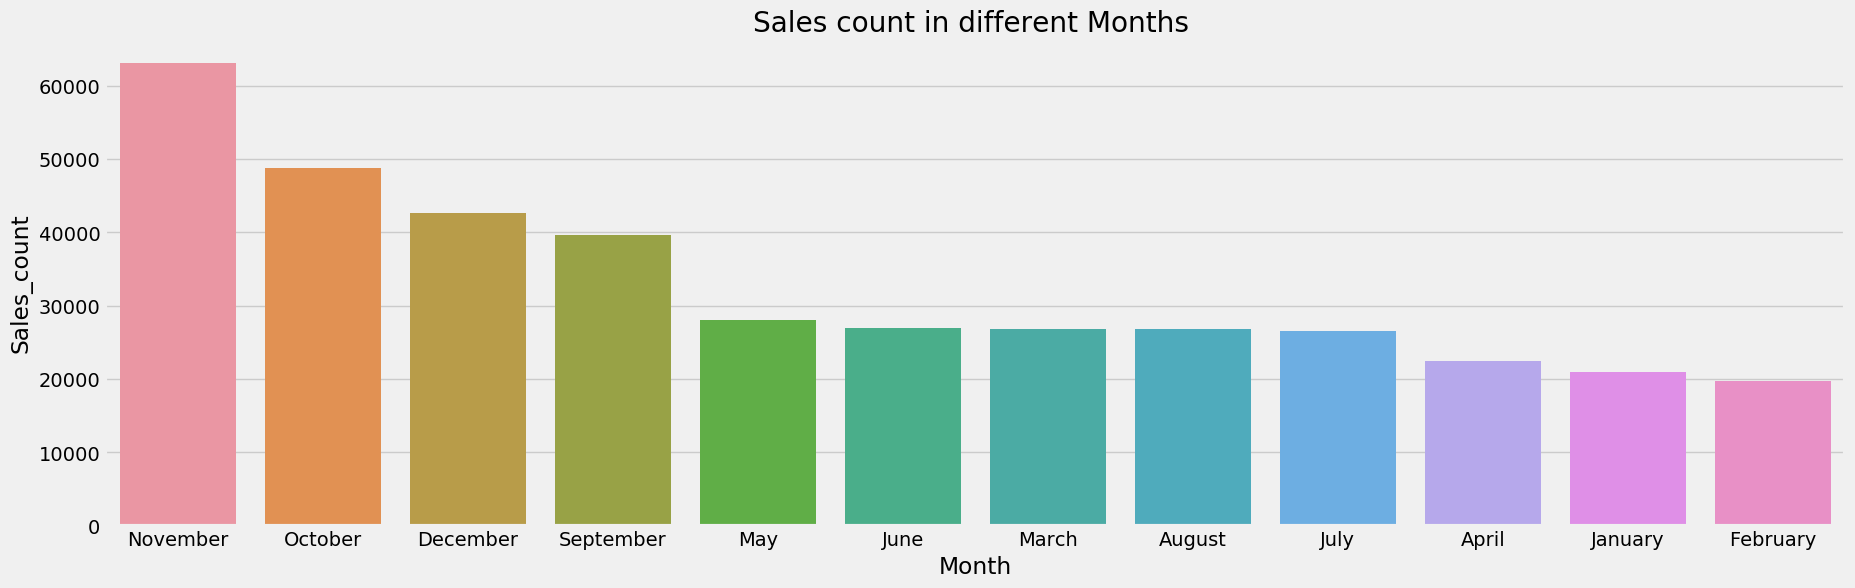

In [64]:
# Sales count in different months.
plt.figure(figsize=(20,6))
sns.barplot(x=sales_in_month['Month'],y=sales_in_month['Sales_count'])
plt.title('Sales count in different Months ')

**Observations:**

    - Most of the sale happened in Novmenber month.*
    - February Month had least sales

In [65]:
sales_on_day_basis=df_copy['Day_of_Week'].value_counts().reset_index().rename(columns={'index':'Day_of_Week',"Day_of_Week":'Sale_count'})
sales_on_day_basis

Day_of_Week  Sale_count
0    Thursday       79243
1   Wednesday       68040
2     Tuesday       65743
3      Monday       64231
4      Sunday       61211
5      Friday       54221

Text(0.5, 1.0, 'Sales count on different Days ')

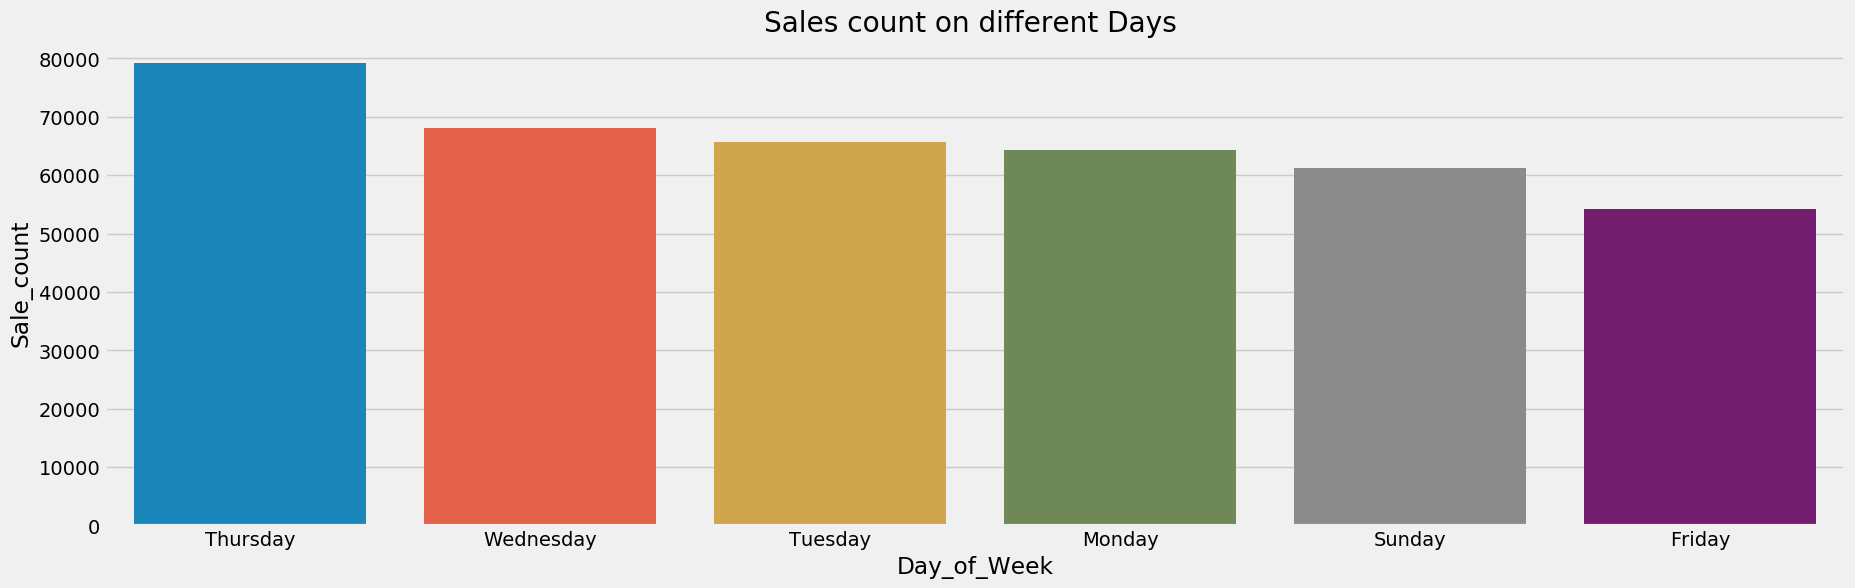

In [66]:
# Sales count on different days.
plt.figure(figsize=(20,6))
sns.barplot(x=sales_on_day_basis['Day_of_Week'],y=sales_on_day_basis['Sale_count'])
plt.title('Sales count on different Days ')

**Observation:**

    - Sales On Thursdays are very high.
    - Sales On Fridays are very less.

In [67]:
df_copy['Hour'].unique()

array([14, 10, 12, 17, 15, 13, 16,  9,  8, 11, 20, 18, 19,  7,  6],
      dtype=int64)

In [68]:
sales_timing=df_copy['Day_part'].value_counts().reset_index().rename(columns={'index':'Day_part','Day_part':'Sales_count'})
sales_timing

Day_part  Sales_count
0  afternoon       255712
1    morning       117130
2    evening        19847

Text(0.5, 1.0, 'Sales count in different day timings')

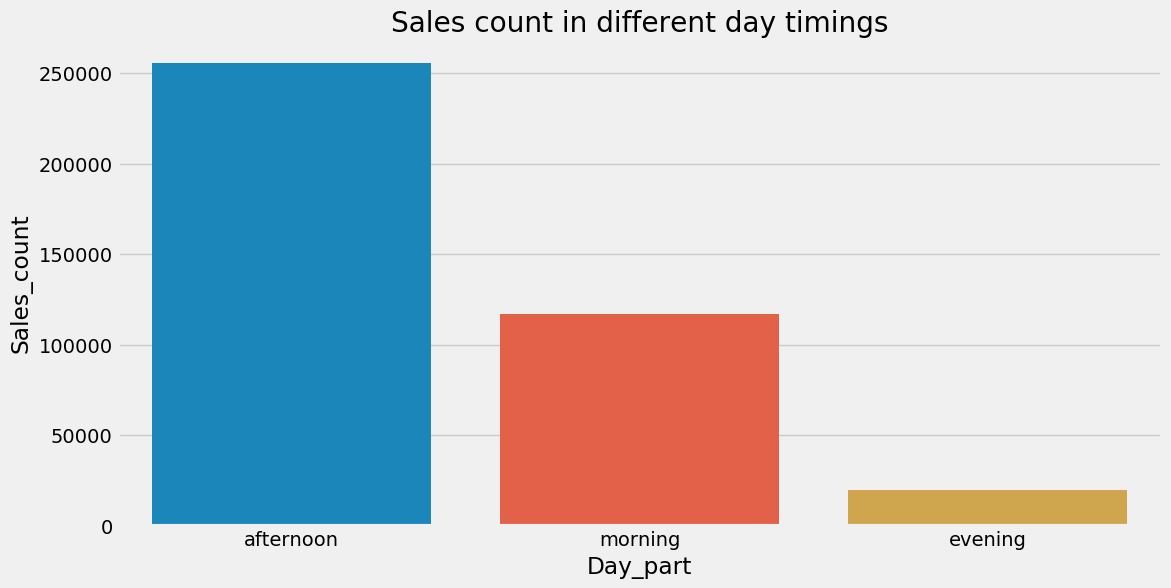

In [69]:
# Sales count on different days.
plt.figure(figsize=(12,6))
sns.barplot(x=sales_timing['Day_part'],y=sales_timing['Sales_count'])
plt.title('Sales count in different day timings')

**Observations:**

    - Most of the sales happens in the afternoon.*
    - Least sales happens in the evening.*

In [70]:
df_copy.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total_Sales', 'Year',
       'Month_num', 'day_num', 'Hour', 'Minute', 'Day_of_Week', 'Month',
       'Day_part'],
      dtype='object')

In [71]:
avg_amount=df_copy.groupby('CustomerID')['Total_Sales'].mean().reset_index().rename(columns={'Total_Sales':'Avg_amount_per_customer'}).sort_values('Avg_amount_per_customer',ascending=False)

In [72]:
avg_amount

CustomerID  Avg_amount_per_customer
2010     15098.0             13305.500000
2501     15749.0              4453.430000
2086     15195.0              3861.000000
596      13135.0              3096.000000
4012     17846.0              2033.100000
...          ...                      ...
696      13271.0                 2.430920
989      13684.0                 2.245862
3994     17816.0                 2.150588
2314     15503.0                 2.136970
3007     16446.0                 1.450000

[4337 rows x 2 columns]

Text(0.5, 1.0, 'Average amount spent by each Customer')

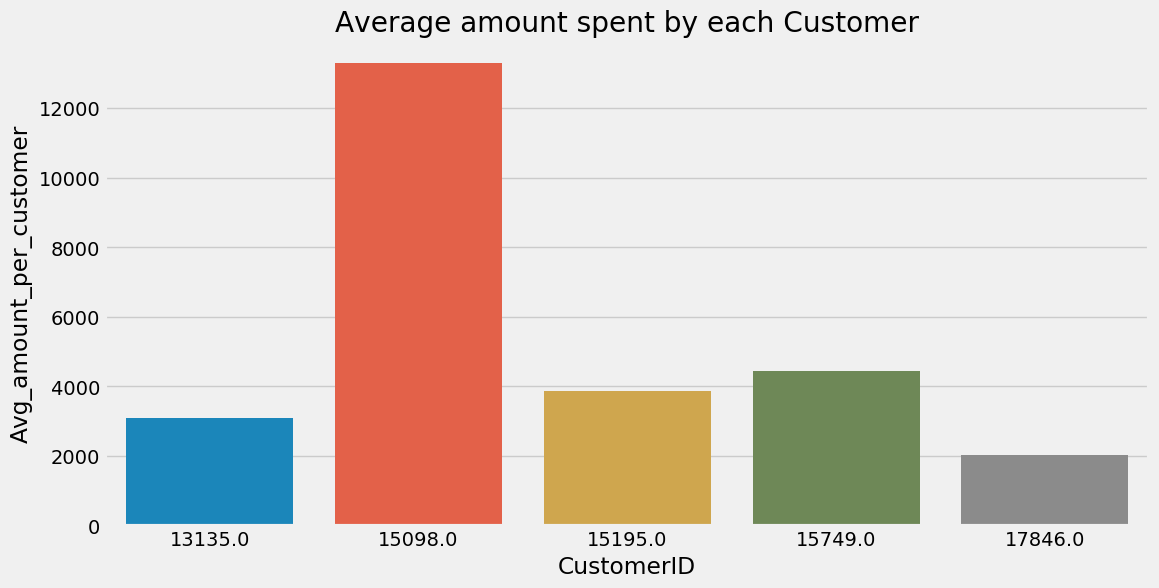

In [73]:
# Sales count on different days.
plt.figure(figsize=(12,6))
sns.barplot(x=avg_amount['CustomerID'].head(5),y=avg_amount['Avg_amount_per_customer'].head(15))
plt.title('Average amount spent by each Customer')

### EDA of cancellations

In [74]:
df_C.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8905 entries, 415 to 162458
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    8905 non-null   object        
 1   StockCode    8905 non-null   object        
 2   Description  8905 non-null   object        
 3   Quantity     8905 non-null   int64         
 4   InvoiceDate  8905 non-null   datetime64[ns]
 5   UnitPrice    8905 non-null   float64       
 6   CustomerID   8905 non-null   float64       
 7   Country      8905 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 626.1+ KB


In [75]:
df_C.head(10)

InvoiceNo StockCode                        Description  Quantity  \
415    C549269    75049L       LARGE CIRCULAR MIRROR MOBILE        -9   
487    C572109     23064             CINDERELLA CHANDELIER         -1   
613    C537860     22180                     RETROSPOT LAMP        -1   
834    C560540     23240  SET OF 4 KNICK KNACK TINS DOILEY         -1   
874    C542910     20726                 LUNCH BAG WOODLAND        -1   
1336   C563570     21067            VINTAGE RED TEATIME MUG       -23   
1343   C568416     23168       CLASSIC CAFE SUGAR DISPENSER        -6   
1429   C549666     21470      FLOWER VINE RAFFIA FOOD COVER        -1   
1440   C560855     21156          RETROSPOT CHILDRENS APRON        -1   
1480   C550709     21232     STRAWBERRY CERAMIC TRINKET BOX        -1   

             InvoiceDate  UnitPrice  CustomerID         Country  
415  2011-04-07 12:47:00       0.85     16701.0  United Kingdom  
487  2011-10-20 18:24:00      49.95     13350.0  United Kingdom  
613  2010-12-08 16:15:00       9.95     16252.0  United Kingdom  
834  2011-07-19 12:26:00       4.15     12415.0       Australia  
874  2011-02-01 15:38:00       1.45     17511.0  United Kingdom  
1336 2011-08-17 14:51:00       1.06     17949.0  United Kingdom  
1343 2011-09-27 11:08:00       1.04     14866.0  United Kingdom  
1429 2011-04-11 12:17:00       3.75     13113.0  United Kingdom  
1440 2011-07-21 13:00:00       1.95     14410.0  United Kingdom  
1480 2011-04-20 10:53:00       1.25     12997.0  United Kingdom

In [76]:
country_cancellations = df_C.groupby('Country').count()['InvoiceNo'].reset_index().sort_values("InvoiceNo",ascending=False)
country_cancellations.rename(columns={'InvoiceNo': 'Cancellations'}, inplace=True)
country_cancellations.head()

Country  Cancellations
27  United Kingdom           7533
11         Germany            453
7             EIRE            247
10          France            149
26             USA            112

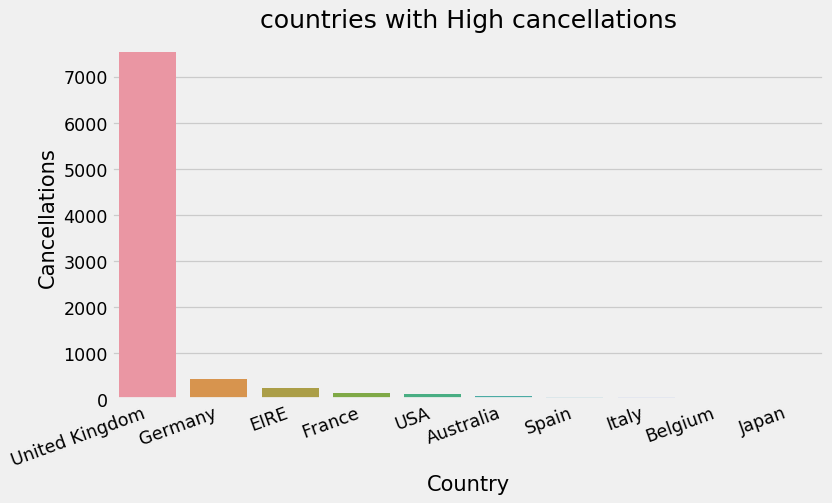

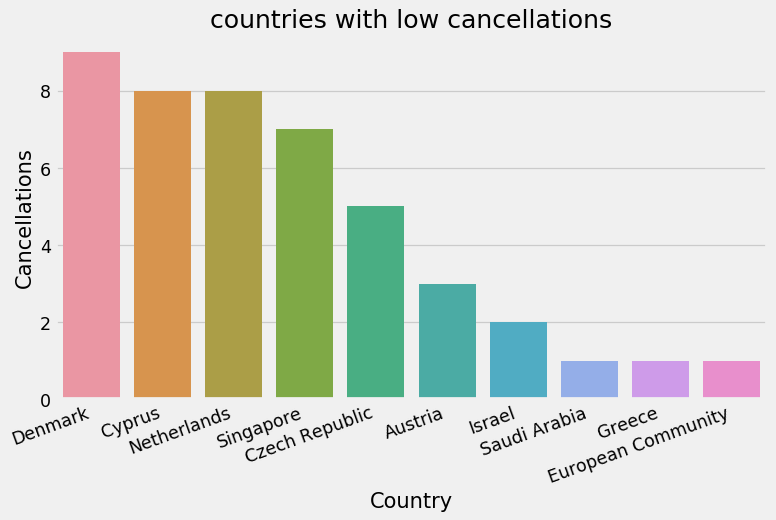

In [77]:
# Visualizing top and bottom 10 countries based on cancellations 
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("countries with High cancellations")
sns.barplot(data=country_cancellations.head(10),x="Country",y="Cancellations")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("countries with low cancellations")
sns.barplot(data=country_cancellations.tail(10),x="Country",y="Cancellations")
plt.show()

In [78]:
# Checking the number of cancellations by each customer. 
customer_cancellations = df_C.groupby('CustomerID').count()['InvoiceNo'].reset_index().sort_values("InvoiceNo",ascending=False)
customer_cancellations.rename(columns={'InvoiceNo': 'Cancellations'}, inplace=True)
customer_cancellations.head()

CustomerID  Cancellations
736      14911.0            226
1485     17841.0            136
1397     17511.0            113
848      15311.0            112
89       12607.0            101

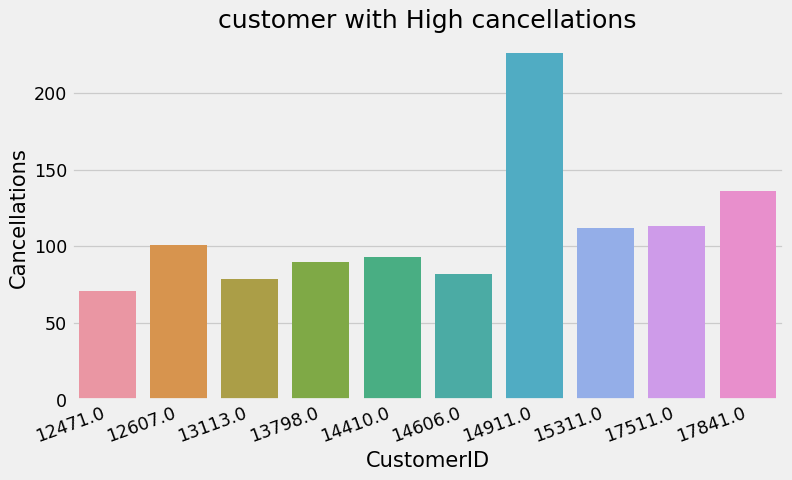

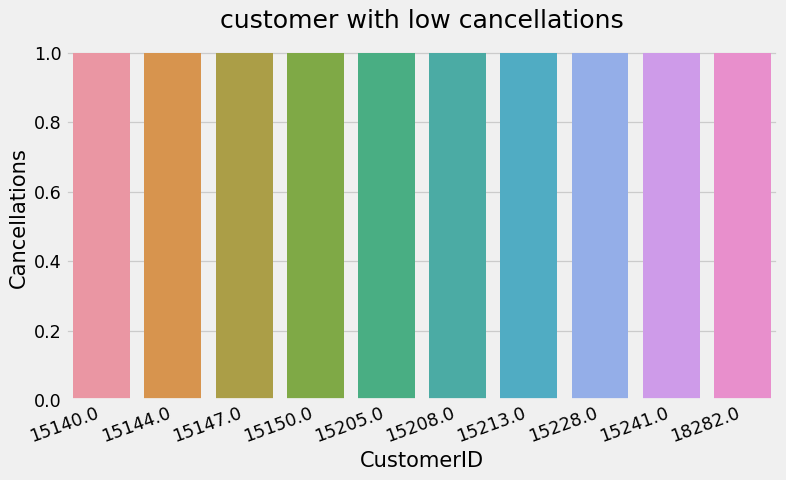

In [79]:
# Visualizing top and bottom 10 customers based on cancellations 
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("customer with High cancellations")
sns.barplot(data=customer_cancellations.head(10),x="CustomerID",y="Cancellations")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("customer with low cancellations")
sns.barplot(data=customer_cancellations.tail(10),x="CustomerID",y="Cancellations")
plt.show()

In [80]:
# Checking the number of cancellations countrywise. 
country_cancellations = df_C.groupby('Country').count()['InvoiceNo'].reset_index().sort_values("InvoiceNo",ascending=False)
country_cancellations.rename(columns={'InvoiceNo': 'Cancellations'}, inplace=True)
country_cancellations.head()

Country  Cancellations
27  United Kingdom           7533
11         Germany            453
7             EIRE            247
10          France            149
26             USA            112

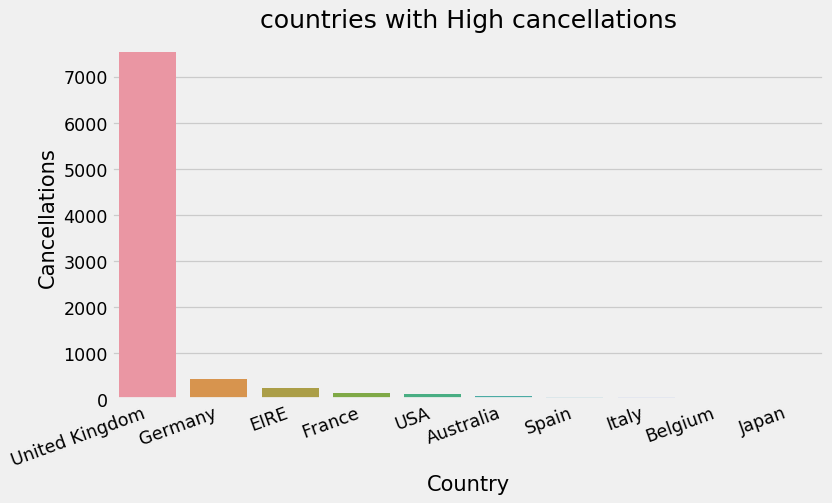

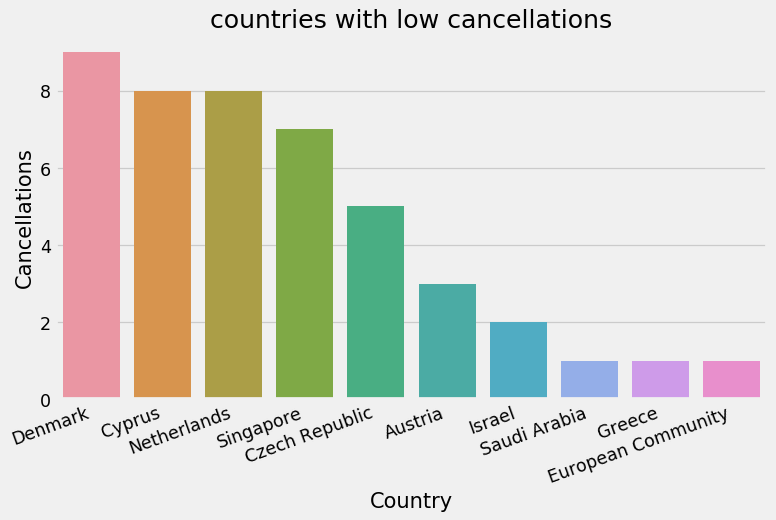

In [81]:
# Visualizing top and bottom 10 countries based on cancellations 
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("countries with High cancellations")
sns.barplot(data=country_cancellations.head(10),x="Country",y="Cancellations")

plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("countries with low cancellations")
sns.barplot(data=country_cancellations.tail(10),x="Country",y="Cancellations")
plt.show()

#### Time range of the dataset:

In [82]:
# Oldest date:
df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [83]:
# Newest date:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

## TASK: Data Transformation:

Perform cohort analysis (a cohort is a group of subjects that share a defining characteristic). Observe how a cohort behaves across time and compare it to other cohorts. 

 * Create month cohorts and analyze active customers for each cohort.

 * Analyze the retention rate of customers.

### Cohort Analysis
The dataset we are using for this example does not contain the customer sign-up date — the date when they registered with the retailer. That is why we assume that the cohort they belong to is based on the first purchase date. A possible downside of this approach is that the dataset does not contain the past data, and what we already see in this snapshot (between 01/12/2010 and 09/12/2011) includes recurring clients and only a data for a year. That means the first purchase date in the dataset might not be the actual date for the given client. Also maximum recency cannot be more than 365+8 days which is the time period the data available for this dataset.

As the first step we have already removed duplicate values.

As the second step we create cohort and order_monthly variables. The first one indicates the monthly cohort based on the first purchase date (calculated per customer). The latter one is the truncated month of the purchase date. 









In [84]:
# Creating a copy of the cleaned data
df_cohort = df.copy()

In [85]:
# As we have only 9 days information of December 2011, so we would not use that for cohort analysis.
df_cohort = df_cohort[~(df_cohort['InvoiceDate'] > '2011-12-01')]

In [86]:
df_cohort.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
Total_Sales           float64
dtype: object

In [87]:
# Extracting month and year column from the Invoice date column
df_cohort['invoice_month'] = df_cohort['InvoiceDate'].apply(lambda x: x.strftime('%Y-%m'))
df_cohort.head()

InvoiceNo StockCode                         Description  Quantity  \
1    556072     20970  PINK FLORAL FELTCRAFT SHOULDER BAG         8   
2    551739     21559   STRAWBERRY LUNCH BOX WITH CUTLERY         2   
3    541658     21988        PACK OF 6 SKULL PAPER PLATES         1   
4    538364    85099C      JUMBO  BAG BAROQUE BLACK WHITE        10   
5    552306     84789           ENCHANTED BIRD PLANT CAGE         4   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_Sales  \
1 2011-06-08 14:57:00       3.75     16126.0  United Kingdom        30.00   
2 2011-05-04 10:58:00       2.55     18118.0  United Kingdom         5.10   
3 2011-01-20 12:16:00       0.85     15529.0  United Kingdom         0.85   
4 2010-12-10 17:26:00       1.95     14448.0  United Kingdom        19.50   
5 2011-05-08 15:20:00       3.75     13911.0  United Kingdom        15.00   

  invoice_month  
1       2011-06  
2       2011-05  
3       2011-01  
4       2010-12  
5       2011-05

In [88]:
df.shape

(392689, 9)

In [89]:
month_grp = df_cohort.groupby('invoice_month')
month_grp_agg = month_grp.agg({'CustomerID': pd.Series.nunique, 'Description': pd.Series.nunique,'Quantity': np.sum, 'Total_Sales': np.sum})

month_grp_agg.rename(columns ={'CustomerID':'# customers', 'Description':'tot_item_types',}, inplace = True)

month_grp_agg


# customers  tot_item_types  Quantity  Total_Sales
invoice_month                                                    
2010-12                885            2418    311044   570414.330
2011-01                740            2117    274258   490917.710
2011-02                758            2122    265027   446084.920
2011-03                974            2240    347582   594081.760
2011-04                856            2225    291366   468374.331
2011-05               1056            2255    372864   677355.150
2011-06                991            2361    363014   660046.050
2011-07                949            2373    367360   598962.901
2011-08                935            2386    397373   644051.040
2011-09               1266            2581    543652   950690.202
2011-10               1364            2681    591543  1035642.450
2011-11               1664            2719    665923  1156205.610

In [90]:
#Creating Label for customer cohort
df_cohort.set_index('CustomerID', inplace = True)
df_cohort.head()

InvoiceNo StockCode                         Description  Quantity  \
CustomerID                                                                     
16126.0       556072     20970  PINK FLORAL FELTCRAFT SHOULDER BAG         8   
18118.0       551739     21559   STRAWBERRY LUNCH BOX WITH CUTLERY         2   
15529.0       541658     21988        PACK OF 6 SKULL PAPER PLATES         1   
14448.0       538364    85099C      JUMBO  BAG BAROQUE BLACK WHITE        10   
13911.0       552306     84789           ENCHANTED BIRD PLANT CAGE         4   

                   InvoiceDate  UnitPrice         Country  Total_Sales  \
CustomerID                                                               
16126.0    2011-06-08 14:57:00       3.75  United Kingdom        30.00   
18118.0    2011-05-04 10:58:00       2.55  United Kingdom         5.10   
15529.0    2011-01-20 12:16:00       0.85  United Kingdom         0.85   
14448.0    2010-12-10 17:26:00       1.95  United Kingdom        19.50   
13911.0    2011-05-08 15:20:00       3.75  United Kingdom        15.00   

           invoice_month  
CustomerID                
16126.0          2011-06  
18118.0          2011-05  
15529.0          2011-01  
14448.0          2010-12  
13911.0          2011-05

In [91]:
df_cohort['cust_cohort'] = df_cohort.groupby(level=0)['InvoiceDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df_cohort.head()

InvoiceNo StockCode                         Description  Quantity  \
CustomerID                                                                     
16126.0       556072     20970  PINK FLORAL FELTCRAFT SHOULDER BAG         8   
18118.0       551739     21559   STRAWBERRY LUNCH BOX WITH CUTLERY         2   
15529.0       541658     21988        PACK OF 6 SKULL PAPER PLATES         1   
14448.0       538364    85099C      JUMBO  BAG BAROQUE BLACK WHITE        10   
13911.0       552306     84789           ENCHANTED BIRD PLANT CAGE         4   

                   InvoiceDate  UnitPrice         Country  Total_Sales  \
CustomerID                                                               
16126.0    2011-06-08 14:57:00       3.75  United Kingdom        30.00   
18118.0    2011-05-04 10:58:00       2.55  United Kingdom         5.10   
15529.0    2011-01-20 12:16:00       0.85  United Kingdom         0.85   
14448.0    2010-12-10 17:26:00       1.95  United Kingdom        19.50   
13911.0    2011-05-08 15:20:00       3.75  United Kingdom        15.00   

           invoice_month cust_cohort  
CustomerID                            
16126.0          2011-06     2011-02  
18118.0          2011-05     2010-12  
15529.0          2011-01     2010-12  
14448.0          2010-12     2010-12  
13911.0          2011-05     2011-02

In [92]:
df_cohort.reset_index(inplace = True)
df_cohort.head()

CustomerID InvoiceNo StockCode                         Description  \
0     16126.0    556072     20970  PINK FLORAL FELTCRAFT SHOULDER BAG   
1     18118.0    551739     21559   STRAWBERRY LUNCH BOX WITH CUTLERY   
2     15529.0    541658     21988        PACK OF 6 SKULL PAPER PLATES   
3     14448.0    538364    85099C      JUMBO  BAG BAROQUE BLACK WHITE   
4     13911.0    552306     84789           ENCHANTED BIRD PLANT CAGE   

   Quantity         InvoiceDate  UnitPrice         Country  Total_Sales  \
0         8 2011-06-08 14:57:00       3.75  United Kingdom        30.00   
1         2 2011-05-04 10:58:00       2.55  United Kingdom         5.10   
2         1 2011-01-20 12:16:00       0.85  United Kingdom         0.85   
3        10 2010-12-10 17:26:00       1.95  United Kingdom        19.50   
4         4 2011-05-08 15:20:00       3.75  United Kingdom        15.00   

  invoice_month cust_cohort  
0       2011-06     2011-02  
1       2011-05     2010-12  
2       2011-01     2010-12  
3       2010-12     2010-12  
4       2011-05     2011-02

In [93]:
cust_grp = df_cohort.groupby(['cust_cohort','invoice_month'])

cust_grp_agg = cust_grp.agg({'CustomerID': pd.Series.nunique, 'Description': pd.Series.nunique,
                      'Quantity': np.sum, 'Total_Sales': np.sum})

cust_grp_agg.rename(columns ={'CustomerID':'# customers', 'Description':'tot_item_types',}, inplace = True)

cust_grp_agg.head()

# customers  tot_item_types  Quantity  Total_Sales
cust_cohort invoice_month                                                    
2010-12     2010-12                885            2418    311044    570414.33
            2011-01                324            1787    158440    275734.47
            2011-02                286            1697    136642    233390.47
            2011-03                340            1834    177170    302367.44
            2011-04                321            1781    131185    204034.38

In [94]:
def cohort_num(df_cohort):
    df_cohort['cohort_num'] = np.arange(len(df_cohort)) + 1
    return df_cohort

cust_grp_agg = cust_grp_agg.groupby(level=0).apply(cohort_num)
cust_grp_agg.head(14)

# customers  tot_item_types  Quantity  Total_Sales  \
cust_cohort invoice_month                                                       
2010-12     2010-12                885            2418    311044    570414.33   
            2011-01                324            1787    158440    275734.47   
            2011-02                286            1697    136642    233390.47   
            2011-03                340            1834    177170    302367.44   
            2011-04                321            1781    131185    204034.38   
            2011-05                352            1851    178267    336113.69   
            2011-06                321            1871    178357    313668.16   
            2011-07                309            1954    176898    310304.03   
            2011-08                313            1951    206035    331001.07   
            2011-09                350            2138    249535    471792.13   
            2011-10                331            2079    255211    455478.90   
            2011-11                445            2286    294807    512341.08   
2011-01     2011-01                416            1807    115818    215183.24   
            2011-02                 92             976     29517     54993.86   

                           cohort_num  
cust_cohort invoice_month              
2010-12     2010-12                 1  
            2011-01                 2  
            2011-02                 3  
            2011-03                 4  
            2011-04                 5  
            2011-05                 6  
            2011-06                 7  
            2011-07                 8  
            2011-08                 9  
            2011-09                10  
            2011-10                11  
            2011-11                12  
2011-01     2011-01                 1  
            2011-02                 2

Text(0.5, 1.0, 'Retention Rates Across Cohorts')

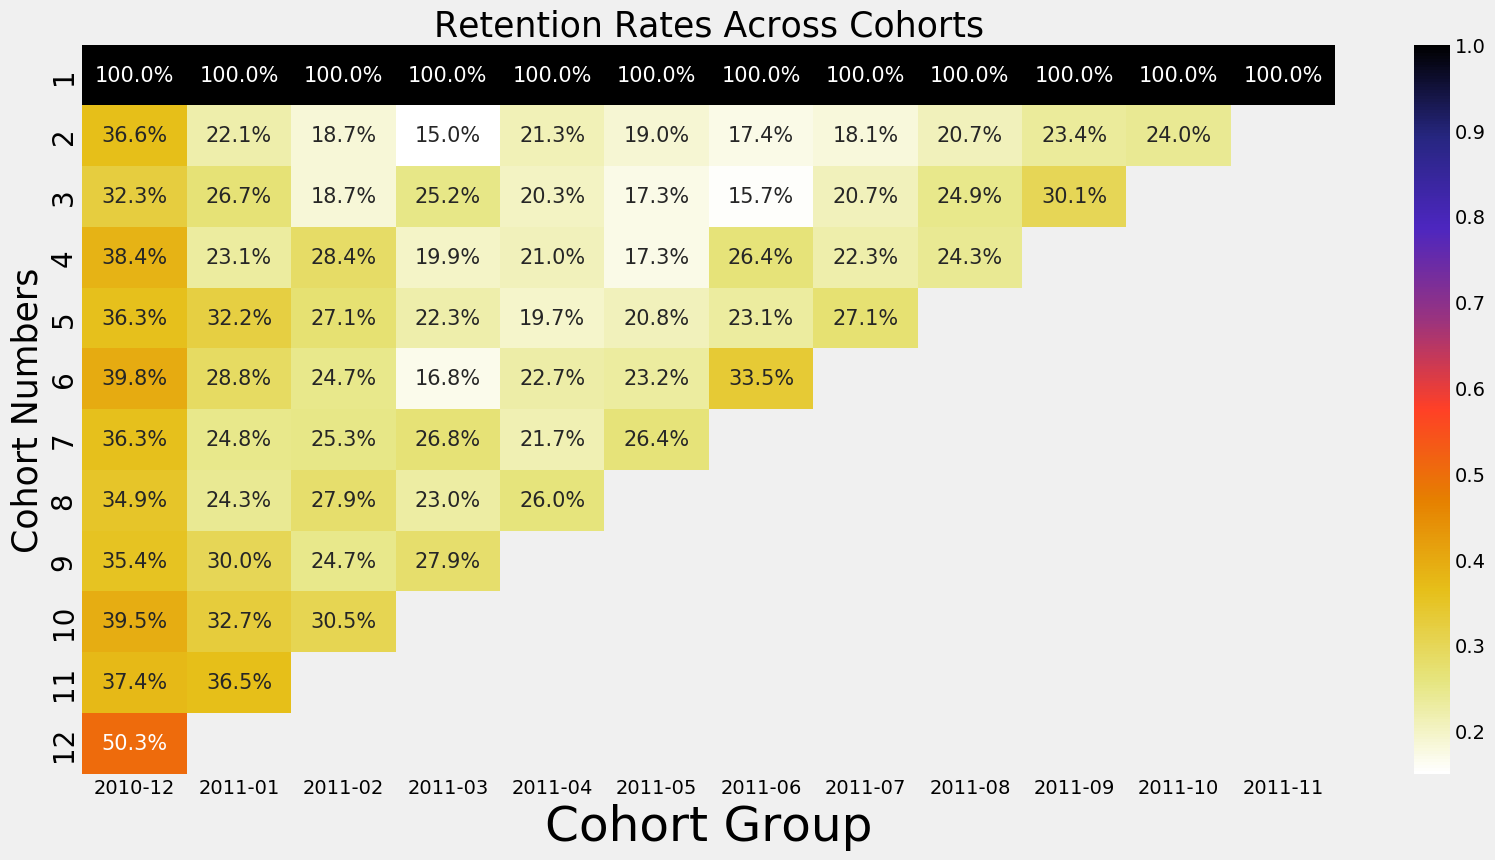

In [95]:
cust_grp_agg.reset_index(inplace=True)
cust_grp_agg.set_index(['cust_cohort', 'cohort_num'], inplace=True)

cohort_size = cust_grp_agg.groupby(level=0)['# customers'].first()
retention_rate = cust_grp_agg['# customers'].unstack(0).divide(cohort_size, axis = 1)

plt.figure(figsize=(18,9))
plt.style.use('_classic_test_patch')
ax = sns.heatmap(retention_rate, annot=True,cmap='CMRmap_r', fmt='.1%', annot_kws={'size': 15})
ax.set_ylabel('Cohort Numbers', fontsize = 25)
ax.set_xlabel('Cohort Group', fontsize = 35)
#ax.set_xticklabels(labels = df_cohort['cust_cohort'], size = '18')
ax.set_yticklabels(labels = [1,2,3,4,5,6,7,8,9,10,11,12], size = '20')
ax.set_title('Retention Rates Across Cohorts', fontsize = 25)

**Obseravtion:**
***
The first cohort (2010–12) seems to be an exception and performs surprisingly well as compared to the other ones. A year after the first purchase, there is a 50% retention.
***

Text(0.5, 1.0, 'Monthly Total Sales Across Cohorts')

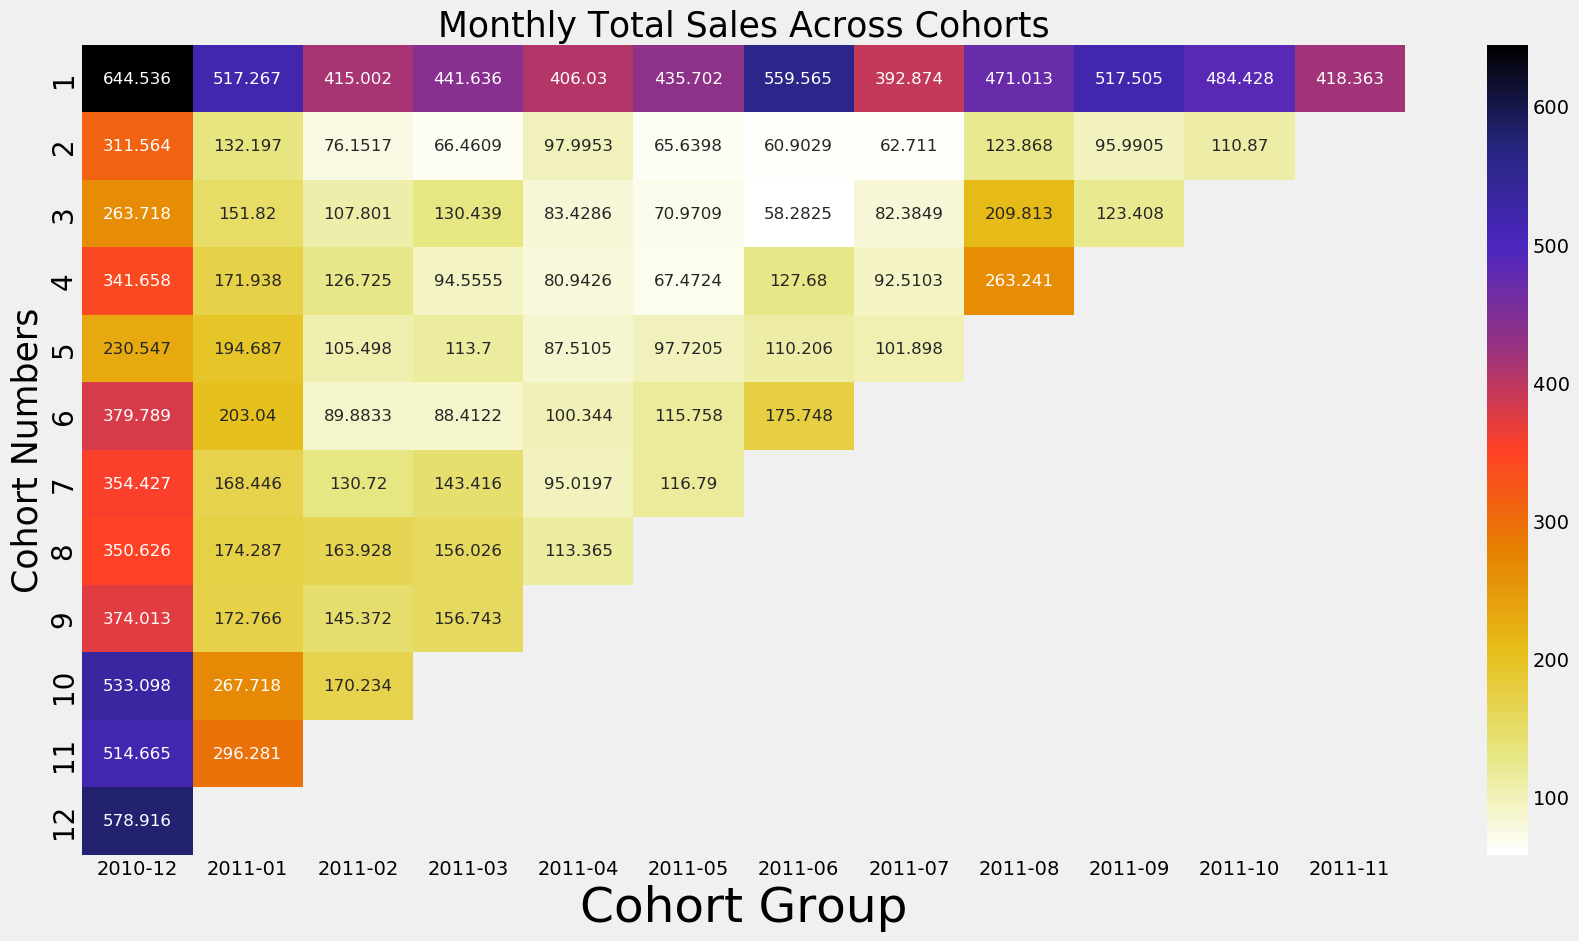

In [96]:
cust_grp_agg.reset_index(inplace=True)
cust_grp_agg.set_index(['cust_cohort', 'cohort_num'], inplace=True)

cohort_size = cust_grp_agg.groupby(level=0)['# customers'].first()
retention_rate = cust_grp_agg['Total_Sales'].unstack(0).divide(cohort_size, axis = 1)

plt.figure(figsize=(19,10))
plt.style.use('_classic_test_patch')
ax = sns.heatmap(retention_rate, annot=True,cmap='CMRmap_r', fmt='g', annot_kws={'size': 12})
ax.set_ylabel('Cohort Numbers', fontsize = 25)
ax.set_xlabel('Cohort Group', fontsize = 35)
#ax.set_xticklabels(labels = df_cohort['cust_cohort'], size = '18')
ax.set_yticklabels(labels = [1,2,3,4,5,6,7,8,9,10,11,12], size = '20')
ax.set_title('Monthly Total Sales Across Cohorts', fontsize = 25)

Text(0.5, 1.0, 'Active Customers Across Cohorts')

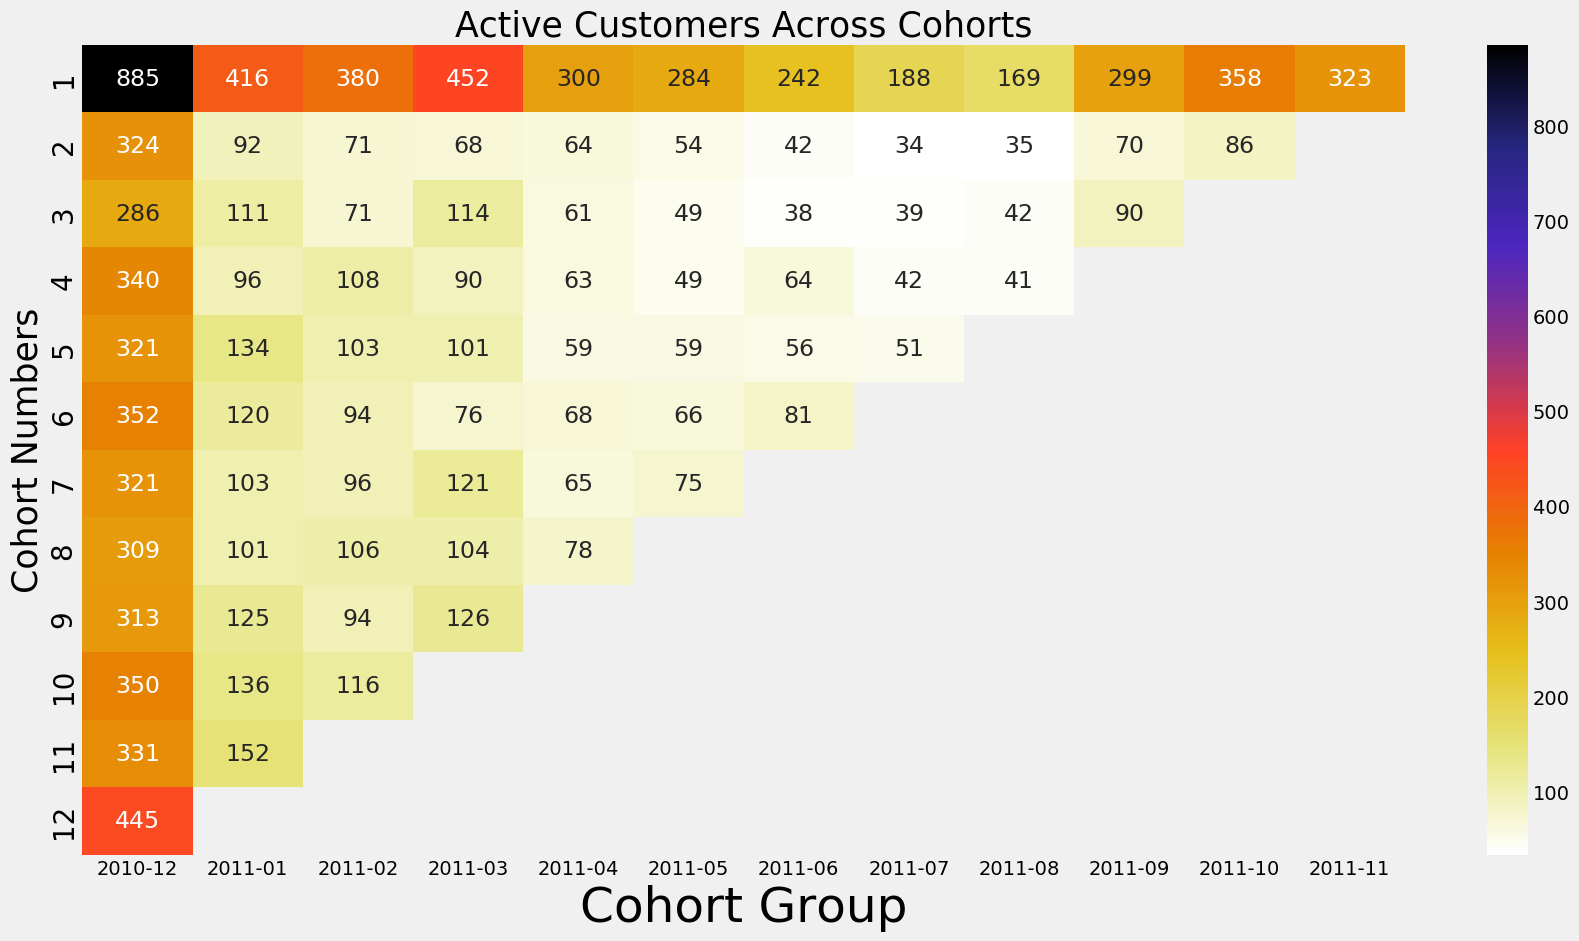

In [97]:
unstacked_cust = cust_grp_agg['# customers'].unstack(0)
plt.figure(figsize=(19,10))
plt.style.use('_classic_test_patch')
ax = sns.heatmap(unstacked_cust, annot = True, cmap='CMRmap_r', fmt = 'g', annot_kws={'size': 17})
ax.set_ylabel('Cohort Numbers', fontsize = 25)
ax.set_xlabel('Cohort Group', fontsize = 35)
#ax.set_xticklabels(labels = df_cohort['cust_cohort'], size = '18')
ax.set_yticklabels(labels = [1,2,3,4,5,6,7,8,9,10,11,12], size = '20')
ax.set_title('Active Customers Across Cohorts', fontsize = 25)

**Obseravtion:**
***
While not entirely representative as these are only sale figures across a single year, it is clear that the number of customers and sales figures are much higher for the first 2010–12 cohort. A more representative way of understanding this cohort is that they are existing customer that have a prior relationship with this store. It is thus natural for them to demonstrate much higher customer engagement and activity.

There also seems to be a slight seasonal factor underlying the sales of this online retailer. Initial purchases are higher in the first and last quarters of the year. Similarly, purchases from the 2010–12 cohort indicate higher activity during these two quarters as well. As most of the products are gifts, this increased activity could be attributed to the holiday season represented by these time periods due to festivals.
***

## RFM Modelling
1. Since Most of the Customers are wholesalers we cannot group customers based on the demographic group like age, gender, income and behavioral and psycho-graphic group Because the Customers purchase bunch of goods and sell it to individual customers.
2. The company only need to deal issues and make clusters related to B2B Business to Business instead of B2C i.e. Direct from Business to Customers.

WHY BECAUSE PEOPLE WHO PURCHASE PRODUCTS FROM THE COMPANY DO NOT UTILIZE OR CONSUME IT. They sell it to individual customers(B2C) or sell all products to another stores (B2B)

3. Due to all these reasons we need to cluster customers according to there activities i.e

    1. **R**- **Recency**: the number of days since a customer made the last order. If it’s a case for a website or an app, this could be interpreted as the last visit day or the last login time. The refence date could be any day as such today() or last date of the whole data set or any day between them.
    
    2. **F**- **Frequency**: the number of purchases made in a given period. It could be 3 months, 6 months or 1 year or any other. So we can understand this value as for how often or how many a customer used the product of a company. The bigger the value is, the more engaged the customers are. Could we say them as our VIP? Not necessary. Cause we also have to think about how much they actually paid for each purchase, which means monetary value.
    
    3. **M**- **Monetary**:  the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers such as MVP or VIP.
    
   
Therefore, big spenders will be differentiated among other customers such
as MVP (Minimum Viable Product) or VIP.
Calculate RFM metrics.

Build RFM Segments. Give recency, frequency, and monetary scores individually by dividing them into quartiles.

    b1. Combine three ratings to get a RFM segment (as strings).
    b2. Get the RFM score by adding up the three ratings.
    b3. Analyze the RFM segments by summarizing them and comment on the findings.

Note: Rate “recency" for customer who has been active more recently higher than the less recent customer, because each company wants its customers to be recent.

Note: Rate “frequency" and “monetary" higher, because the company wants the customer to visit more often and spend more money.

The RFM values can be grouped in several ways:

    1.Percentiles e.g. quantiles
    2.Pareto 80/20 cut
    3.Custom - based on business knowledge

We are going to implement percentile-based grouping.

Process of calculating percentiles:

    Sort customers based on that metric
    Break customers into a pre-defined number of groups equal size
    Assign a label to each group


In [98]:
rfm_df=df.copy(deep=True)

In [99]:
rfm_df.shape

(392689, 9)

In [152]:
# Adding 1 day to the Invoice Date to set as reference point as the lastest date
last_date = df['InvoiceDate'].max()

In [101]:
# Creating a new dataframe to calculate Recency, Frequency and Monetary scores for each customer
RFM_table = rfm_df.groupby('CustomerID').agg({'InvoiceDate':lambda x: (last_date - x.max()).days,
                                  'InvoiceNo': lambda x: len(x),
                                  'Total_Sales': lambda x: x.sum()})

#Remaning the columns
RFM_table.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'Total_Sales': 'Monetary'}, inplace=True)
RFM_table.head(10)


Recency  Frequency  Monetary
CustomerID                              
12347.0           1        182   4310.00
12348.0          74         31   1797.24
12349.0          18         73   1757.55
12350.0         309         17    334.40
12352.0          35         85   2506.04
12353.0         203          4     89.00
12354.0         231         58   1079.40
12355.0         213         13    459.40
12356.0          22         59   2811.43
12357.0          32        131   6207.67

In [103]:
RFM_table_copy= RFM_table.copy()


**Interpretation:**

We will rate "Recency" customer who have been active more recently better than the less recent customer,because each company wants its customers to be recent We will rate "Frequency" and "Monetary Value" higher label because we want a Customer to spend more money and visit more often (that is different order than recency).

By spliting Recency, Frequency, Monetary based on quantiles as explained below:

***Recency:*** Lower the number of days better the recency R When labelling we use in the reverse order.\
***Frequency:*** Higher the Frequency better the F.\
***Monetary:*** Higher the Monetray better the M.

1. If the RFM of any customer is 444 ('R'=4, 'F'=4, 'M'=4). His Recency is good, frequency is more and Monetary is more. So, he is the best customer.
2. If the RFM of any customer is 111. His Recency is low, frequency is low and Monetary is low. So, he is the churning customer.
3. If the RFM of any customer is 144. He purchased a long time ago but buys frequently and spends more. And so on.

Like this we can come up with number of segments for all combinations of R,F and M base on our usecase. Higher the RFM score, more valuable the customer is.

In [104]:

RFM_table_copy['R'] = pd.qcut(RFM_table_copy['Recency'], q=4, labels=[4,3,2,1]).astype(int) # reverse order
RFM_table_copy['F'] = pd.qcut(RFM_table_copy['Frequency'], q=4, labels=[1,2,3,4]).astype(int)
RFM_table_copy['M'] = pd.qcut(RFM_table_copy['Monetary'], q=4, labels=[1,2,3,4]).astype(int)

# Finding the RFM Group for each customer by combining the factors R,Fand M
RFM_table_copy['RFM'] = 100*RFM_table_copy['R'] + 10*RFM_table_copy['F'] + RFM_table_copy['M']

# Finding the RFM Score for each customer by adding the factors R,Fand M
RFM_table_copy['RFM_Score'] = RFM_table_copy['R'] + RFM_table_copy['F'] + RFM_table_copy['M']
RFM_table_copy.head()

Recency  Frequency  Monetary  R  F  M  RFM  RFM_Score
CustomerID                                                       
12347.0           1        182   4310.00  4  4  4  444         12
12348.0          74         31   1797.24  2  2  4  224          8
12349.0          18         73   1757.55  3  3  4  334         10
12350.0         309         17    334.40  1  1  2  112          4
12352.0          35         85   2506.04  3  3  4  334         10

In [105]:
RFM_table_copy.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean', 'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           259.6       8.2    157.0   382
4           176.2      13.6    240.0   388
5           151.9      21.2    366.6   518
6            94.6      28.0    651.9   454
7            78.6      37.9    759.3   464
8            63.0      55.9    986.6   455
9            45.1      78.9   1391.5   413
10           31.4     110.5   2056.4   426
11           20.3     186.9   4062.0   387
12            6.2     367.8   9285.9   450

In [106]:
# Checking Descriptive Stats
RFM_table_copy.describe()

Recency    Frequency       Monetary            R            F  \
count  4337.000000  4337.000000    4337.000000  4337.000000  4337.000000   
mean     91.529859    90.543924    1992.517246     2.513489     2.488356   
std      99.968030   225.528840    8547.583167     1.126200     1.122528   
min       0.000000     1.000000       2.900000     1.000000     1.000000   
25%      17.000000    17.000000     306.450000     2.000000     1.000000   
50%      50.000000    41.000000     668.430000     3.000000     2.000000   
75%     141.000000    98.000000    1657.280000     4.000000     3.000000   
max     373.000000  7676.000000  280206.020000     4.000000     4.000000   

                 M          RFM    RFM_Score  
count  4337.000000  4337.000000  4337.000000  
mean      2.499654   278.732073     7.501499  
std       1.118266   118.818880     2.817571  
min       1.000000   111.000000     3.000000  
25%       1.000000   211.000000     5.000000  
50%       2.000000   311.000000     7.000000  
75%       3.000000   411.000000    10.000000  
max       4.000000   444.000000    12.000000

In [107]:
RFM_table_copy.head()

Recency  Frequency  Monetary  R  F  M  RFM  RFM_Score
CustomerID                                                       
12347.0           1        182   4310.00  4  4  4  444         12
12348.0          74         31   1797.24  2  2  4  224          8
12349.0          18         73   1757.55  3  3  4  334         10
12350.0         309         17    334.40  1  1  2  112          4
12352.0          35         85   2506.04  3  3  4  334         10

In [108]:
RFM_table_copy.groupby(['RFM']).size().sort_values(ascending=False)[:5]

RFM
444    450
111    382
344    217
122    206
211    179
dtype: int64

### Customer Segmentation

Use RFM score to group customers into Platinum, Gold, Silver and Bronze segments. We will select the segment depend on the RFM_Score distribution and dividing into equal 4 parts where the highest score segment goes into Platinum and lowest into Bronz 

In [109]:

Segment = ['Bronz','Silver','Gold','Platinum']

Score_cut = pd.qcut(RFM_table_copy['RFM_Score'],q = 4,labels=Segment)
RFM_table_copy['Segment'] = Score_cut.values
#RFM_table_copy.reset_index().head(10)

In [110]:
RFM_table_segment = RFM_table_copy.copy()
RFM_table_segment.head()

Recency  Frequency  Monetary  R  F  M  RFM  RFM_Score   Segment
CustomerID                                                                 
12347.0           1        182   4310.00  4  4  4  444         12  Platinum
12348.0          74         31   1797.24  2  2  4  224          8      Gold
12349.0          18         73   1757.55  3  3  4  334         10      Gold
12350.0         309         17    334.40  1  1  2  112          4     Bronz
12352.0          35         85   2506.04  3  3  4  334         10      Gold

In [111]:
RFM_table_segment.to_excel('RFM_Segment.xlsx')

In [112]:
Segment = ['Bronz','Silver','Gold','Platinum']

Score_cut = pd.qcut(RFM_table_copy['RFM_Score'],q = 4,labels=Segment)
RFM_table_copy['Segment'] = Score_cut.values


In [113]:
RFM_table_segment.Segment.value_counts()
RFM_table_segment.Recency

CustomerID
12347.0      1
12348.0     74
12349.0     18
12350.0    309
12352.0     35
          ... 
18280.0    277
18281.0    180
18282.0      7
18283.0      3
18287.0     42
Name: Recency, Length: 4337, dtype: int64

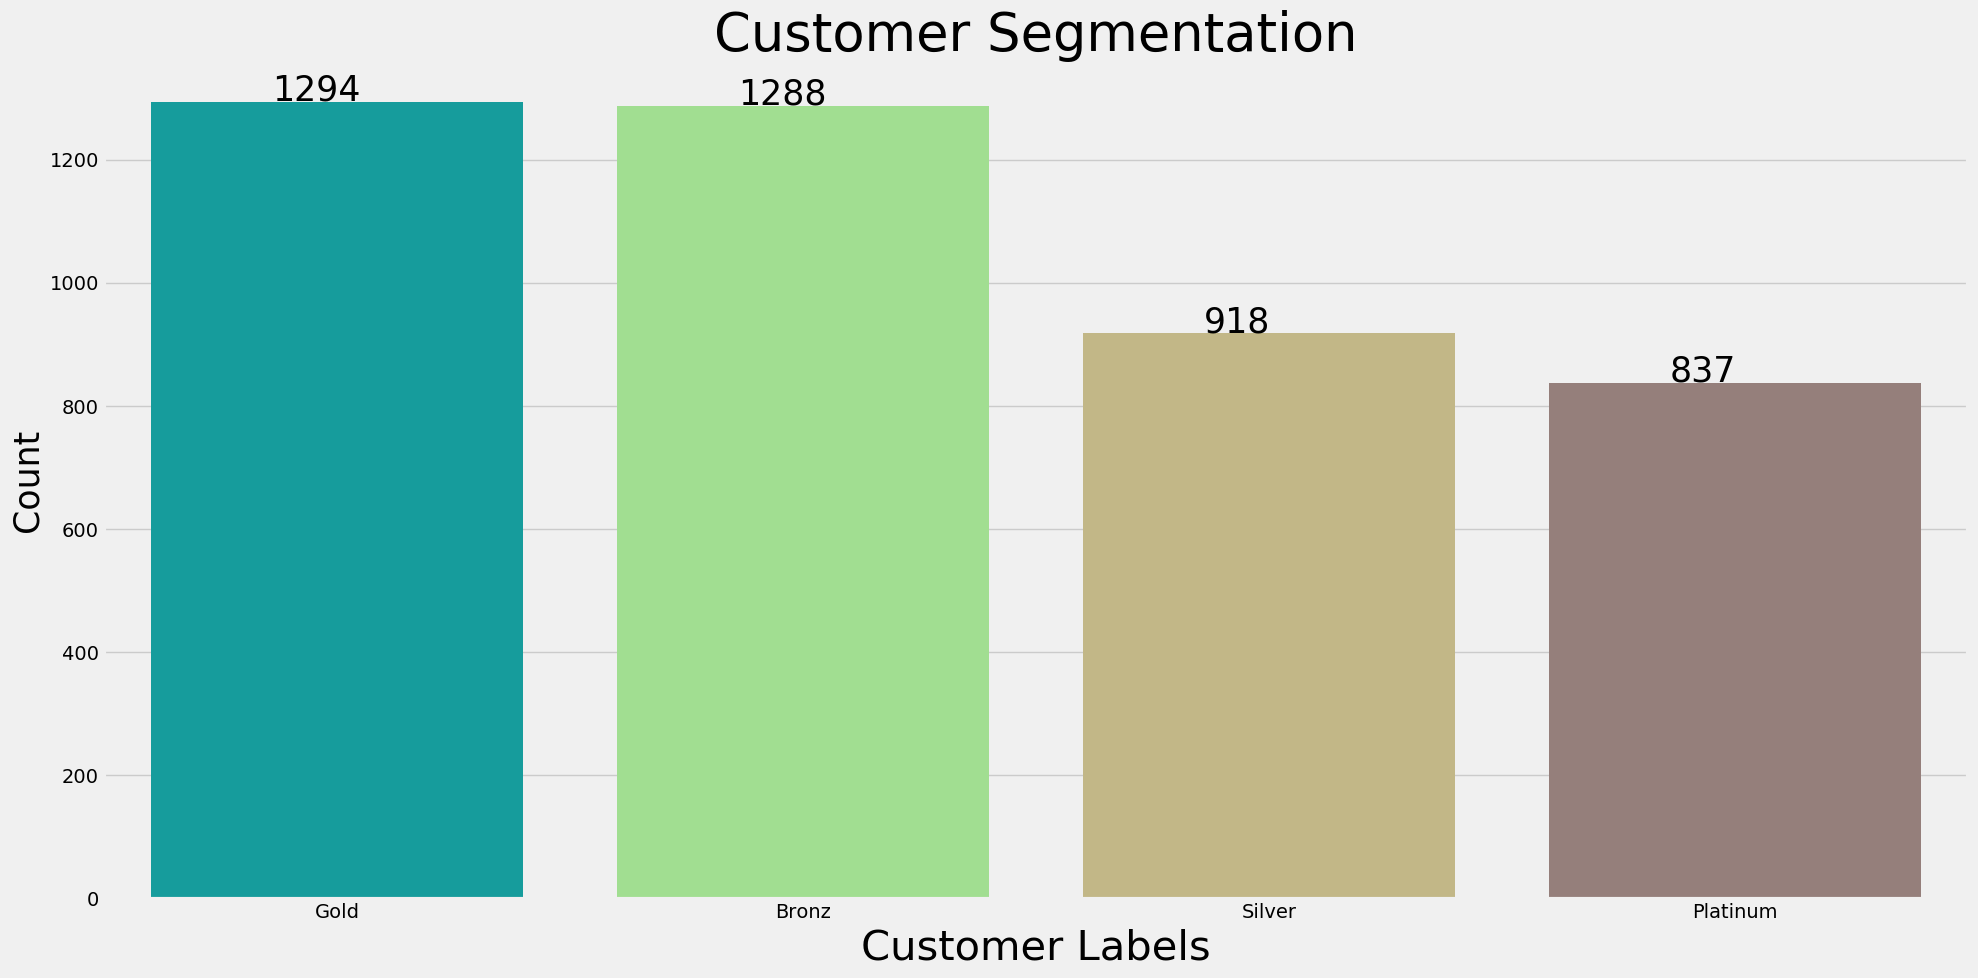

In [114]:
plt.figure(figsize=(20,10))
plt.style.use('_classic_test_patch')
ax = sns.countplot(x='Segment', data=RFM_table_copy, palette="terrain", order=RFM_table_copy['Segment'].value_counts().index[:5])
ax.set_ylabel('Count', fontsize = 25)
ax.set_xlabel('Customer Labels', fontsize = 30)
#ax.set_xticklabels(rfm_table['Label'].index, fontsize = 25)
ax.set_title('Customer Segmentation', fontsize = 38);

value_ticks = []
for x in RFM_table_copy['Segment'].value_counts():
    value_ticks.append(str(int(x)))

for a, label in zip(ax.patches, value_ticks):
    ax.annotate(label, (a.get_x() + 0.26, a.get_height() + 2), fontsize = 25)

    plt.tight_layout()

In [115]:
RFM_table_copy.groupby('Segment').agg({'Recency':'mean', 'Frequency':'mean', 'Monetary':['mean','count']}).round(1)

Recency Frequency Monetary      
            mean      mean     mean count
Segment                                  
Bronz      191.2      15.1    266.3  1288
Silver      86.5      33.0    706.2   918
Gold        46.9      81.3   1468.0  1294
Platinum    12.8     284.2   6870.5   837

### Data Transformation

Data Pre-Processing for Kmeans Clustering:

We must check these Key k-means assumptions before we implement our Kmeans Clustering Mode:

    - Symmetric distribution of variables (not skewed)
    - Variables with same average values
    - Variables with same variance

#### LogTransformation

Logarithmic transformation (positive values only) will manage skewness. We use these Sequence of structuring pre-processing steps:

    Unskew the data - log transformation
    Standardize to the same average values
    Scale to the same standard deviation
    Store as a separate array to be used for clustering

Why the sequence matters?
Log transformation only works with positive data. If Normalization happens first, it forces data to have negative values and then log will not work.



In [116]:
df_rfm_log = RFM_table.copy()
df_rfm_log.describe()

Recency    Frequency       Monetary
count  4337.000000  4337.000000    4337.000000
mean     91.529859    90.543924    1992.517246
std      99.968030   225.528840    8547.583167
min       0.000000     1.000000       2.900000
25%      17.000000    17.000000     306.450000
50%      50.000000    41.000000     668.430000
75%     141.000000    98.000000    1657.280000
max     373.000000  7676.000000  280206.020000

In [117]:
# Handling the zeroes so as to handle infinite numbers during log transformation

df_rfm_log.replace(0.0,1,inplace=True)

# Applying Log transformation on columns for smoothening the distribution
df_rfm_log['Recency_Log']   = df_rfm_log['Recency'].apply(np.log)
df_rfm_log['Frequency_Log'] = df_rfm_log['Frequency'].apply(np.log)
df_rfm_log['Monetary_Log']  = df_rfm_log['Monetary'].apply(np.log)
df_rfm_log.head()

Recency  Frequency  Monetary  Recency_Log  Frequency_Log  \
CustomerID                                                             
12347.0           1        182   4310.00     0.000000       5.204007   
12348.0          74         31   1797.24     4.304065       3.433987   
12349.0          18         73   1757.55     2.890372       4.290459   
12350.0         309         17    334.40     5.733341       2.833213   
12352.0          35         85   2506.04     3.555348       4.442651   

            Monetary_Log  
CustomerID                
12347.0         8.368693  
12348.0         7.494007  
12349.0         7.471676  
12350.0         5.812338  
12352.0         7.826459

In [118]:
df_rfm_log.describe()

Recency    Frequency       Monetary  Recency_Log  Frequency_Log  \
count  4337.000000  4337.000000    4337.000000  4337.000000    4337.000000   
mean     91.551072    90.543924    1992.517246     3.707769       3.672274   
std      99.948706   225.528840    8547.583167     1.511386       1.320024   
min       1.000000     1.000000       2.900000     0.000000       0.000000   
25%      17.000000    17.000000     306.450000     2.833213       2.833213   
50%      50.000000    41.000000     668.430000     3.912023       3.713572   
75%     141.000000    98.000000    1657.280000     4.948760       4.584967   
max     373.000000  7676.000000  280206.020000     5.921578       8.945854   

       Monetary_Log  
count   4337.000000  
mean       6.582098  
std        1.259982  
min        1.064711  
25%        5.725055  
50%        6.504932  
75%        7.412933  
max       12.543280

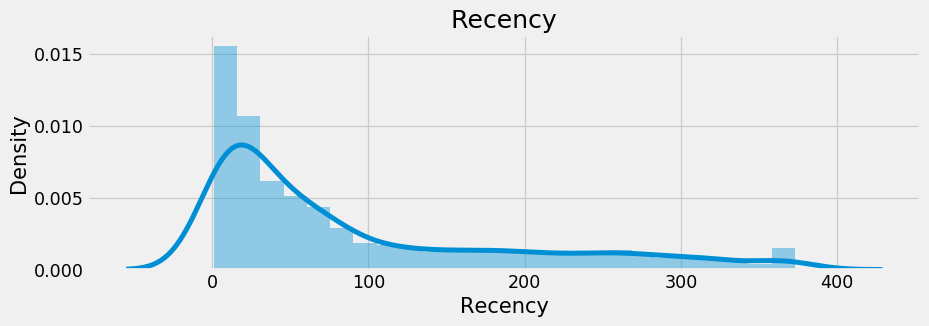

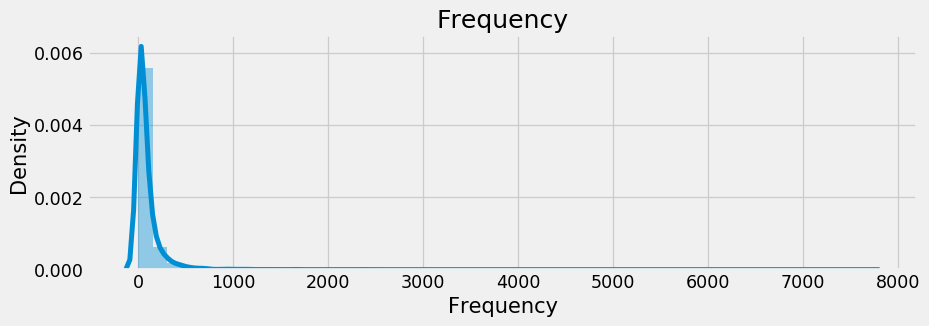

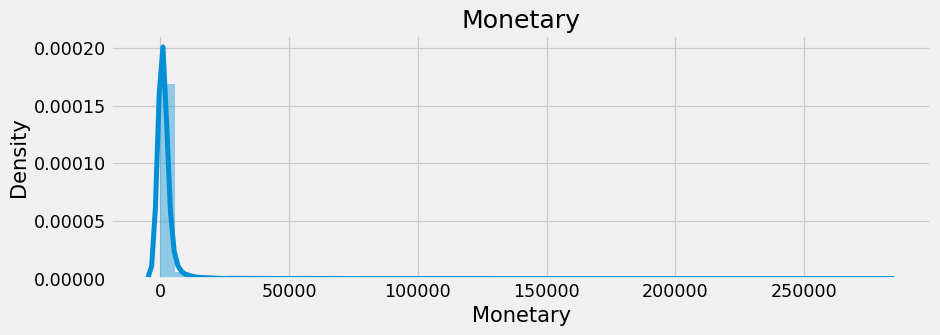

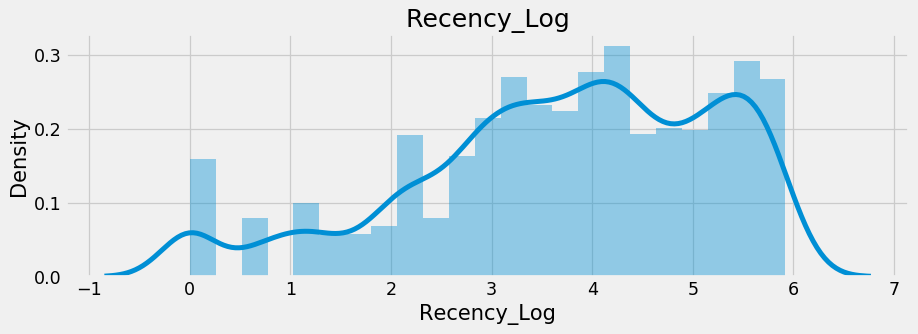

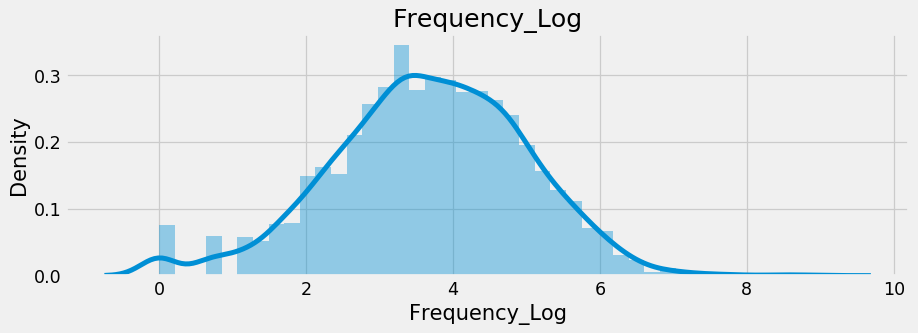

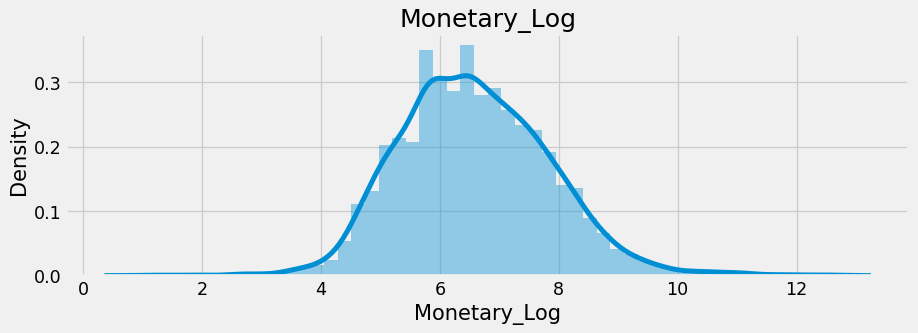

In [119]:

# Visualizing the distributions before and after log transformation.
target = ['Recency', 'Frequency', 'Monetary', 'Recency_Log', 'Frequency_Log', 'Monetary_Log']
#plt.figure(figsize=(20,10), dpi=90)
plt.style.use('fivethirtyeight')

for n,col in enumerate(target):
    plt.figure(figsize=(20,10), dpi=90)
    plt.subplot(3,2, n+1)
    sns.distplot(df_rfm_log[col])
    plt.title(col.title())
    plt.tight_layout()

Observations:

* Charts for the distributions of Recency, Frequency and Monetary columns are positively skewed but after applying log transformation, the distributions appear to be symmetrical and normally distributed.
* It will be more suitable to use the transformed features for better visualisation of clusters.

# Data Modeling :

1. Create clusters using k-means clustering algorithm.

  * Prepare the data for the algorithm. If the data is asymmetrically distributed, manage the skewness with appropriate transformation. Standardize the data.

  * Decide the optimum number of clusters to be formed.

  * Analyze these clusters and comment on the results.

 

2. Create a dashboard in tableau by choosing appropriate chart types and metrics useful for the business. The dashboard must entail the following: 

  * Country-wise analysis to demonstrate average spend. Use a bar chart to show the monthly figures

  * Bar graph of top 15 products which are mostly ordered by the users to show the number of products sold

  * Bar graph to show the count of orders vs. hours throughout the day

  * Plot the distribution of RFM values using histogram and frequency charts

  * Plot error (cost) vs. number of clusters selected

  * Visualize to compare the RFM values of the clusters using heatmap

In [120]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [121]:
RFM_table.describe()

Recency    Frequency       Monetary
count  4337.000000  4337.000000    4337.000000
mean     91.529859    90.543924    1992.517246
std      99.968030   225.528840    8547.583167
min       0.000000     1.000000       2.900000
25%      17.000000    17.000000     306.450000
50%      50.000000    41.000000     668.430000
75%     141.000000    98.000000    1657.280000
max     373.000000  7676.000000  280206.020000

In [122]:
df_rfm_log.head()

Recency  Frequency  Monetary  Recency_Log  Frequency_Log  \
CustomerID                                                             
12347.0           1        182   4310.00     0.000000       5.204007   
12348.0          74         31   1797.24     4.304065       3.433987   
12349.0          18         73   1757.55     2.890372       4.290459   
12350.0         309         17    334.40     5.733341       2.833213   
12352.0          35         85   2506.04     3.555348       4.442651   

            Monetary_Log  
CustomerID                
12347.0         8.368693  
12348.0         7.494007  
12349.0         7.471676  
12350.0         5.812338  
12352.0         7.826459

In [123]:
df_rfm_log = df_rfm_log.drop(['Recency', 'Frequency', 'Monetary'], axis =1)
df_rfm_log.describe()

Recency_Log  Frequency_Log  Monetary_Log
count  4337.000000    4337.000000   4337.000000
mean      3.707769       3.672274      6.582098
std       1.511386       1.320024      1.259982
min       0.000000       0.000000      1.064711
25%       2.833213       2.833213      5.725055
50%       3.912023       3.713572      6.504932
75%       4.948760       4.584967      7.412933
max       5.921578       8.945854     12.543280

In [124]:
# Standardrizing the data
scaler = StandardScaler()
scaler.fit(df_rfm_log)

# Store it separately for clustering
rfm_scaled= scaler.transform(df_rfm_log)

In [125]:
df_rfm_log.head()

Recency_Log  Frequency_Log  Monetary_Log
CustomerID                                          
12347.0        0.000000       5.204007      8.368693
12348.0        4.304065       3.433987      7.494007
12349.0        2.890372       4.290459      7.471676
12350.0        5.733341       2.833213      5.812338
12352.0        3.555348       4.442651      7.826459

In [126]:
RFM_elbow = rfm_scaled.copy()

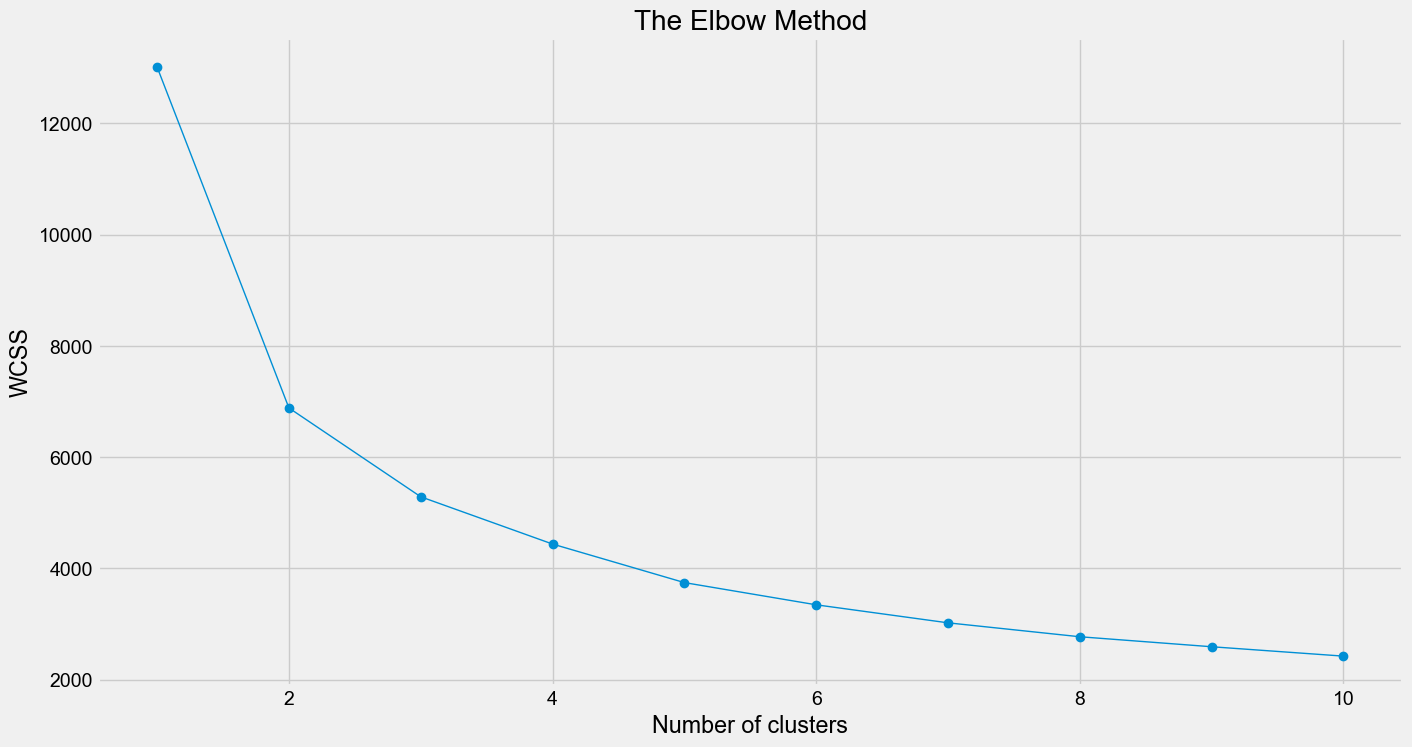

In [127]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(RFM_elbow)
    wcss.append(kmeans.inertia_)

f, ax = plt.subplots(figsize=(15, 8))  
plt.style.use('seaborn-whitegrid')  
plt.plot(range(1, 11), wcss, linewidth=1, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS');

Saving the dataset into a separate file to use later in the Tableau

In [128]:
ElbowPlot = pd.DataFrame({'Cluster': range(1,11) , 'SSE': wcss})
ElbowPlot.to_excel('Elbow_Plot_Data.xlsx')
ElbowPlot

Cluster           SSE
0        1  13011.000000
1        2   6881.985759
2        3   5285.123204
3        4   4435.315045
4        5   3742.417739
5        6   3343.153154
6        7   3019.130348
7        8   2768.799927
8        9   2589.111784
9       10   2420.485683

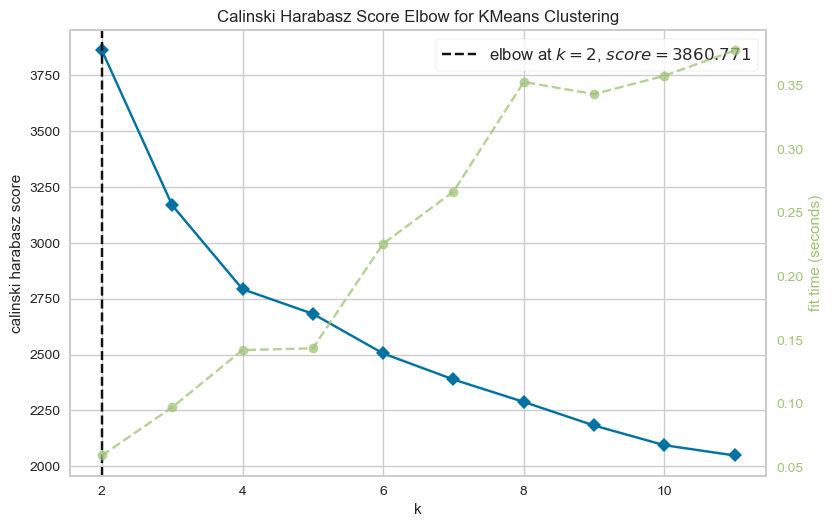

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [129]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', timings=True)

visualizer.fit(RFM_elbow)        # Fit the data to the visualizer
visualizer.poof()
#visualizer.show()    

#model = KMeans()
#visualizer = KElbowVisualizer(model, k=(4,12))

#visualizer.fit(X)    # Fit the data to the visualizer
#visualizer.poof()    # Draw/show/poof the data

In [130]:
visualizer


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 estimator=KMeans(n_clusters=11), k=(2, 12),
                 metric='calinski_harabasz')

In [131]:
#RFM_elbow.head()

#ElbowPlot = pd.DataFrame({'Cluster': range(1,12) , 'SSE': wcss})
##ElbowPlot.to_excel('Elbow_Plot_Data.xlsx')
#ElbowPlot

### Here we can see that Optimal value for cluster came out to be 2.
***Cross verifying with ElbowVisualizar:***
The elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

**Observation:**

Here we can clearly see that optimum number of cluster should be 4. Because that is the only point after which the mean cluster distance looks to be plateaued after a steep downfall. So we will assume the 4 number of clusters as best for grouping of customer segments.

Now let's apply K-Means on 4 clusters to segregate the customer base

In [132]:
kmeans = KMeans(n_clusters=4, random_state=1, init='k-means++')
kmeans.fit(rfm_scaled)
cluster_labels = kmeans.labels_

In [133]:
kmeans

KMeans(n_clusters=4, random_state=1)

In [134]:
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {RFM_table_segment.shape}")

Shape of cluster label array is (4337,)
Shape of RFM segment dataframe is (4337, 9)


In [135]:
# Assign the clusters as column to each customer
Cluster_table = RFM_table_segment.assign(Cluster = cluster_labels)

In [136]:
# Check counts of records assigned to different clusters
Cluster_table.Cluster.value_counts()

1    1421
0    1341
2     794
3     781
Name: Cluster, dtype: int64

In [137]:
Cluster_table[Cluster_table.Cluster == 3].sample(10)

Recency  Frequency  Monetary  R  F  M  RFM  RFM_Score   Segment  \
CustomerID                                                                    
17659.0          16        158   2999.46  4  4  4  444         12  Platinum   
12727.0          10        139   3980.70  4  4  4  444         12  Platinum   
17160.0          30        229   3518.03  3  4  4  344         11  Platinum   
14309.0           7        117   2352.53  4  4  4  444         12  Platinum   
16657.0           9        192    874.43  4  4  3  443         11  Platinum   
15907.0           3        226    882.72  4  4  3  443         11  Platinum   
15194.0           2        310   7616.53  4  4  4  444         12  Platinum   
18179.0           8         90   1793.17  4  3  4  434         11  Platinum   
17188.0          10         84   2474.23  4  3  4  434         11  Platinum   
13838.0           5        165    674.82  4  4  3  443         11  Platinum   

            Cluster  
CustomerID           
17659.0           3  
12727.0           3  
17160.0           3  
14309.0           3  
16657.0           3  
15907.0           3  
15194.0           3  
18179.0           3  
17188.0           3  
13838.0           3

Here it can be seen that the RFM score for Cluster 3 customers with low recency, good frequency and high monetary value, These are the loyal customers to the firm.

In [138]:
Cluster_table[Cluster_table.Cluster == 1].sample(10)

Recency  Frequency  Monetary  R  F  M  RFM  RFM_Score Segment  \
CustomerID                                                                  
14082.0         364         29    182.25  1  2  1  121          4   Bronz   
15171.0         330          5   1289.50  1  1  3  113          5   Bronz   
13144.0         332          3    110.95  1  1  1  111          3   Bronz   
13420.0         149          8    159.85  1  1  1  111          3   Bronz   
16643.0         245         27    487.51  1  2  2  122          5   Bronz   
13856.0         168         14    388.50  1  1  2  112          4   Bronz   
13474.0         235         62    226.84  1  3  1  131          5   Bronz   
15921.0         172         24    323.03  1  2  2  122          5   Bronz   
12824.0          59         25    397.12  2  2  2  222          6  Silver   
14946.0          13          3    100.90  4  1  1  411          6  Silver   

            Cluster  
CustomerID           
14082.0           1  
15171.0           1  
13144.0           1  
13420.0           1  
16643.0           1  
13856.0           1  
13474.0           1  
15921.0           1  
12824.0           1  
14946.0           1

Cluster 1 contains the highest number of customers who accounts for lowest value to the firm because there RFM values are lowest. Most of them are in the lost segment or on the verge of churning out

In [139]:
Cluster_table[Cluster_table.Cluster == 0].sample(10)

Recency  Frequency  Monetary  R  F  M  RFM  RFM_Score   Segment  \
CustomerID                                                                    
14916.0          70         77   1268.98  2  3  3  233          8      Gold   
17204.0         174         57   1564.56  1  3  3  133          7    Silver   
14210.0         105        102   1905.84  2  4  4  244         10      Gold   
16053.0          32         84   1511.95  3  3  3  333          9      Gold   
17692.0         126         46    740.94  2  3  3  233          8      Gold   
14670.0         279        123    392.86  1  4  2  142          7    Silver   
14676.0          30         42   2548.24  3  3  4  334         10      Gold   
14223.0          91         60    991.13  2  3  3  233          8      Gold   
13725.0          49        104   1980.56  3  4  4  344         11  Platinum   
18204.0          70        192   1975.35  2  4  4  244         10      Gold   

            Cluster  
CustomerID           
14916.0           0  
17204.0           0  
14210.0           0  
16053.0           0  
17692.0           0  
14670.0           0  
14676.0           0  
14223.0           0  
13725.0           0  
18204.0           0

Cluster 0 with very high monetary value along with good frequency and recency values. These are the most valuable customers to the firm. They should be looked after periodically to access there concerns

In [140]:
Cluster_table[Cluster_table.Cluster == 2].sample(10)

Recency  Frequency  Monetary  R  F  M  RFM  RFM_Score Segment  \
CustomerID                                                                  
14741.0          11         59   1400.34  4  3  3  433         10    Gold   
14869.0           8         70    721.45  4  3  3  433         10    Gold   
18126.0          60         52    200.92  2  3  1  231          6  Silver   
17359.0          10         15    127.86  4  1  1  411          6  Silver   
17666.0           3         18    728.16  4  2  3  423          9    Gold   
14517.0          32         18    330.45  3  2  2  322          7  Silver   
15267.0          21         11   1717.36  3  1  4  314          8    Gold   
17526.0           4         19   1195.90  4  2  3  423          9    Gold   
16811.0           4         28    547.07  4  2  2  422          8    Gold   
16079.0          16         21   1352.00  4  2  3  423          9    Gold   

            Cluster  
CustomerID           
14741.0           2  
14869.0           2  
18126.0           2  
17359.0           2  
17666.0           2  
14517.0           2  
15267.0           2  
17526.0           2  
16811.0           2  
16079.0           2

Cluster 2 is somewhat average collectively can respond to the targeted campaigns.

In [141]:
def kmeans(rfm_scaled, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(rfm_scaled)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

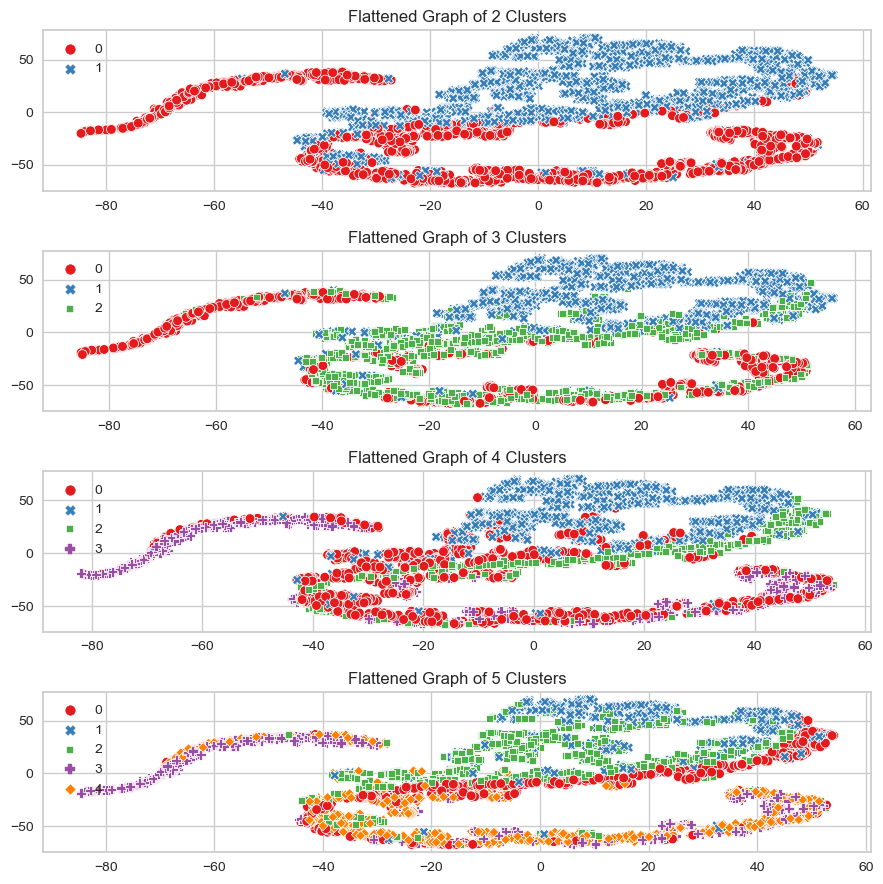

In [142]:
plt.figure(figsize=(9, 9))

plt.subplot(4, 1, 1)
df_rfm_k2 = kmeans(rfm_scaled, 2, RFM_table)

plt.subplot(4, 1, 2)
df_rfm_k3 = kmeans(rfm_scaled, 3, RFM_table)

plt.subplot(4, 1, 3)
df_rfm_k4 = kmeans(rfm_scaled, 4, RFM_table)

plt.subplot(4, 1, 4)
df_rfm_k5 = kmeans(rfm_scaled, 5, RFM_table)

plt.tight_layout()

In [143]:
def wire_plot(rfm_scaled, df_rfm_kmeans, df_rfm_original):
   
       
   
    rfm_scaled = pd.DataFrame(rfm_scaled, 
                                       index=RFM_table.index, 
                                       columns=RFM_table.columns)
    rfm_scaled['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(rfm_scaled.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

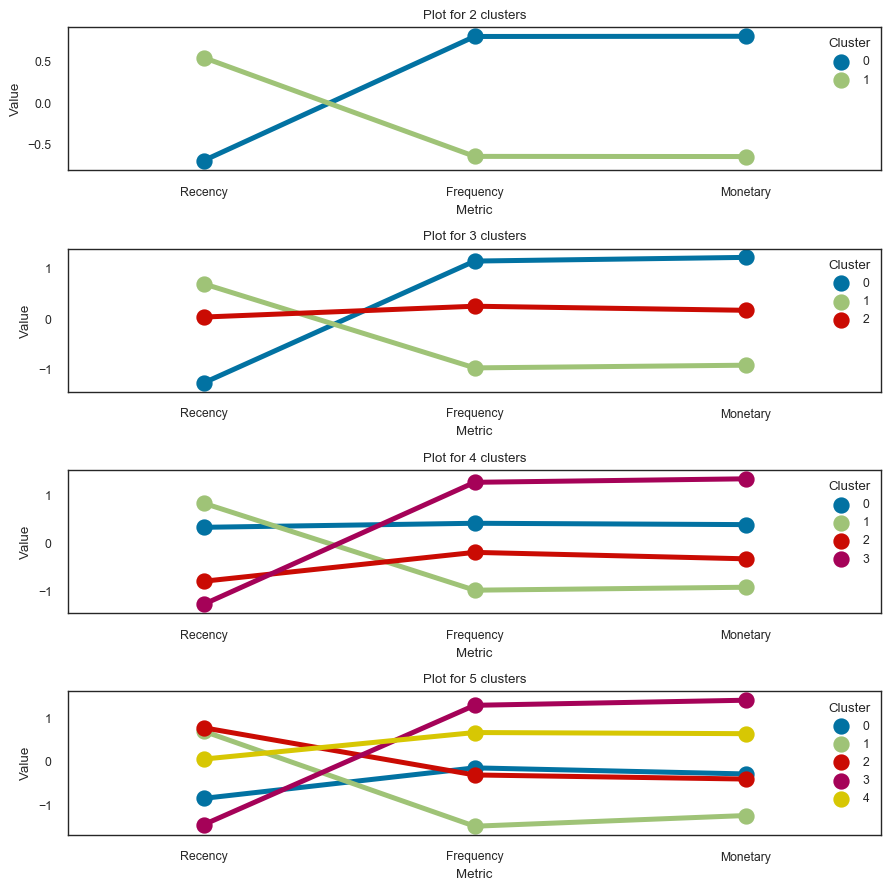

In [144]:
plt.figure(figsize=(9, 9))
sns.set_style("white")
paper_rc = {'lines.linewidth': 2, 'lines.markersize': 8}                  
sns.set_context("paper", rc = paper_rc)

plt.subplot(4, 1, 1)
plt.title('Plot for 2 clusters')
wire_plot(rfm_scaled, df_rfm_k2, RFM_table)

plt.subplot(4, 1, 2)
plt.title('Plot for 3 clusters')
wire_plot(rfm_scaled, df_rfm_k3, RFM_table)

plt.subplot(4, 1, 3)
plt.title('Plot for 4 clusters')
wire_plot(rfm_scaled, df_rfm_k4, RFM_table)

plt.subplot(4, 1, 4)
plt.title('Plot for 5 clusters')
wire_plot(rfm_scaled, df_rfm_k5, RFM_table)

plt.tight_layout()

From the flattened graphs and the snake plots it is evident that having a cluster value of 4, segments our customers well.

We could also go for higher number of clusters, it completely depends on how the company wants to segment their customers.

In [145]:
# clustering
kc = KMeans(n_clusters= 4, random_state=42)
kc.fit(rfm_scaled)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
df_rfm_k4 = df_rfm_log.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
df_rfm_k4.groupby('K_Cluster').agg({'Recency_Log': 'mean','Frequency_Log': 'mean',
                                         'Monetary_Log': ['mean', 'count'],}).round(0)

Recency_Log Frequency_Log Monetary_Log      
                 mean          mean         mean count
K_Cluster                                             
0                 5.0           2.0          5.0  1421
1                 2.0           5.0          8.0   781
2                 3.0           3.0          6.0   794
3                 4.0           4.0          7.0  1341

In [146]:
df_rfm_k4.head()

Recency_Log  Frequency_Log  Monetary_Log  K_Cluster
CustomerID                                                     
12347.0        0.000000       5.204007      8.368693          1
12348.0        4.304065       3.433987      7.494007          3
12349.0        2.890372       4.290459      7.471676          3
12350.0        5.733341       2.833213      5.812338          0
12352.0        3.555348       4.442651      7.826459          3

Lets find out customers in each cluster more closly

#### Heat Map
We will utilize heat map to visualize the relative importance of each ttributes in all four customer segments i.e. clusters. It calculates importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average).

The farther a ratio is from 0, the more important that attribute is for a segment relative to the total population.

In [147]:
# Assign Cluster labels to RFM table
rfm_table_cluster = RFM_table.assign(Cluster = cluster_labels)

# Average attributes for each cluster
cluster_avg = rfm_table_cluster.groupby(['Cluster']).mean() 

# Calculate the population average
population_avg = RFM_table.mean()

# Calculate relative importance of attributes by 
relative_imp = cluster_avg / population_avg - 1

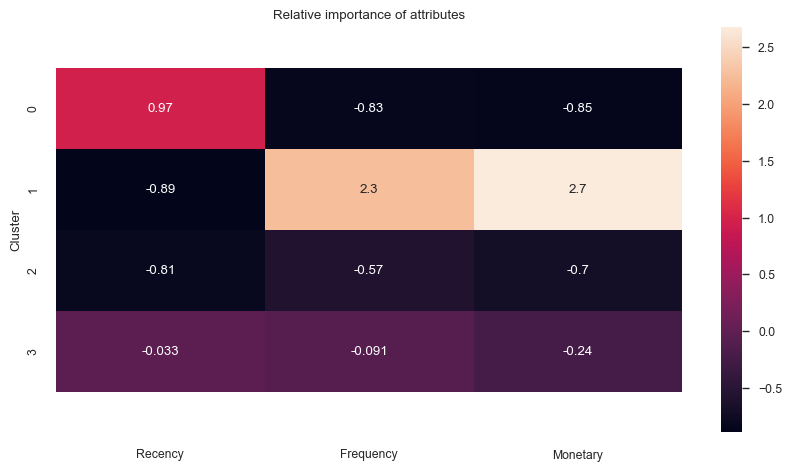

In [148]:
plt.figure(figsize=(9, 5))
plt.title('Relative importance of attributes')

ax = sns.heatmap(relative_imp, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.tight_layout()
#plt.gcf().subplots_adjust(bottom=0.15)
plt.show();

In [149]:
relative_imp

Recency  Frequency  Monetary
Cluster                               
0        0.970185  -0.834039 -0.851075
1       -0.887193   2.252530  2.673988
2       -0.807719  -0.568672 -0.695556
3       -0.033115  -0.091373 -0.243650

In [150]:
relative_imp.to_excel('Heat_map.xlsx')

**Observation:**

### Conclusion

The first cluster belongs to the "Best Customers" / "Platinum Customers" segment as they purchase recently (R=4), frequent buyers (F=1), and spent the most (M=1).

The second cluster can be interpreted as "Newbies" / "Gold" customers as their last purchase is very recent (R=4), purchased very few (F=1) but spent quite a good amount (M=4).Company has to come up with new strategies to make them permanent members.

The third cluster is more related to the "Best Churned Customers" / "Silver Customers" as they have made a purchase for some time (R=3), visited not much (F=2) but have spent a decent amount of money.

The last cluster are belogns to Bronze Cutomers, who are in a mixed fashion and can be classified furthermore to give them the best treatment.

Tableau published link:
https://public.tableau.com/app/profile/ajantha.wirasinghe/viz/CapstonePROJECT3/Dashboard1?publish=yes